In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

from apps import cex_toy_generator, cex_toy_parameters
from IPython.display import clear_output
from python.analysis import cross_section, Plots
from statsmodels.stats.weightstats import ztest as ztest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rich import print
cross_section.SetPlotStyle(True, 140)

def CreateConfig(scales : dict):
    return {
    "events" : 50805,
    "step" : 2,
    "p_init" : 1000,
    "beam_profile" : "gaussian",
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_ff_resolution.json",
        "KE_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int_resolution.json",
        "z_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/track_length_resolution.json"
    },
    "reco_region_fractions" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : scales,
    "blur_strengths" : None,
    "verbose" : False
    }


# def CreateObservedInputData(toy : cross_section.Toy, energy_bins : np.array, mean_track_score_bins : np.array = None, alt_regions : pd.DataFrame = None):
#     toy_observed_binned = []

#     reco_regions = toy.df.filter(regex = "reco_regions") if alt_regions is None else alt_regions.columns 

#     for c in reco_regions:
#         m = toy.df[c] if alt_regions is None else alt_regions[c]
#         toy_observed_binned.append(np.histogram(toy.df.KE_int_smeared[m], bins = energy_bins)[0])
#     if mean_track_score_bins is not None:
#         toy_observed_binned.append(np.histogram(toy.df.mean_track_score[toy.df.inclusive_process != "decay"], mean_track_score_bins)[0])
#     return toy_observed_binned

# def CreateModelInputData(toy : cross_section.Toy, bins : np.array):
#     model_input_data = []
#     for c in toy.df.filter(regex = "reco_regions"):
#         tmp = []
#         for s in toy.df.filter(regex = "truth_regions"):
#             tmp.append(np.histogram(toy.df.KE_int_smeared[toy.df[c] & toy.df[s]], bins = bins)[0])
#         model_input_data.append(tmp)
#     return model_input_data

def SliceModelPrediction(prediction : cross_section.cabinetry.model_utils.ModelPrediction, slice : slice, label : str):
    return cross_section.cabinetry.model_utils.ModelPrediction(prediction.model, np.array(prediction.model_yields[slice]), np.array(prediction.total_stdev_model_bins[slice]), np.array(prediction.total_stdev_model_channels[slice]), label)


def RegionFitToyStudy(toy : cross_section.Toy, model : cross_section.pyhf.Model, energy_slice : cross_section.Slices, mean_track_score_bins : np.array = None, alt_regions : pd.DataFrame = None, pdf : Plots.PlotBook = None):

    fit_input = cross_section.RegionFit.CreateFitInputToy(toy)
    if alt_regions is not None:
        fit_input.regions = alt_regions

    observed = cross_section.RegionFit.GenerateObservations(fit_input, energy_slice, mean_track_score_bins, model)
    result = cross_section.RegionFit.Fit(observed, model, False)

    postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = result)

    #* split post fit results by the observables
    if mean_track_score_bins is not None:
        KE_int_prediction = SliceModelPrediction(postfit_pred, slice(-1), "KE_int_postfit")
        # mean_track_score_prediction = SliceModelPrediction(postfit_pred, slice(len(model.config.channels) - 1, len(model.config.channels)), "mean_track_score_postfit")
    else:
        KE_int_prediction = postfit_pred

    total_count_err = np.sum(np.power(KE_int_prediction.total_stdev_model_channels, 2))**0.5
    total_count = np.sum(KE_int_prediction.model_yields)
    # total_count_actual = np.sum(prefit_pred.model_yields)
    # total_count_actual = sum((toy.df.inclusive_process != "decay") & (toy.df.KE_int_smeared > min(energy_slice.pos)) & (toy.df.KE_int_smeared < max(energy_slice.pos)))

    # Plot fitted correlation matrix and actual
    plot = Plots.MultiPlot(2)
    next(plot)
    # truth_regions_masksed = {t : toy.truth_regions[t] & (((toy.df.KE_int_smeared) > min(energy_slice.pos)) & ((toy.df.KE_int_smeared) < max(energy_slice.pos))) for t in toy.truth_regions}
    # reco_regions_masksed = {r : toy.reco_regions[r] & (((toy.df.KE_int_smeared) > min(energy_slice.pos)) & ((toy.df.KE_int_smeared) < max(energy_slice.pos))) for r in toy.reco_regions} 
    # counts_matrix = cross_section.Toy.ComputeCounts(truth_regions_masksed, reco_regions_masksed)
    counts_matrix = []
    for j in toy.truth_region_labels:
        counts = []
        for i in toy.reco_region_labels:
            counts.append(sum(toy.NInteract(energy_slice, toy.truth_regions[j], toy.reco_regions[i])))
        counts_matrix.append(counts)
    total_count_actual = np.sum(counts_matrix)
    cex_toy_parameters.PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "actual", newFigure = False)
    next(plot)
    counts_matrix = []
    for c in KE_int_prediction.model_yields:
        counts_matrix.append([sum(s) for s in c])
    counts_matrix = np.array(counts_matrix, dtype = int).T
    cex_toy_parameters.PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "fitted", newFigure = False)

    print(f"{total_count_actual, total_count, total_count_err=}")

    if pdf is not None: pdf.Save()

    mu = {}
    for n in model.config.par_names:
        if "mu" in n:
            mu[f"${n}$"] = {"value" : result.bestfit[model.config.par_names.index(n)], "error" : result.uncertainty[model.config.par_names.index(n)]}
    mu = pd.DataFrame(mu)

    # Plot parameters of interest
    Plots.Plot(list(mu.columns), mu.iloc[0], yerr = mu.iloc[1], marker = "o", linestyle = "")
    Plots.plt.xticks(ticks = list(mu.columns), labels = list(mu.columns))
    if pdf is not None: pdf.Save()

    # Plot all fit parameters
    Plots.Plot(np.linspace(0, len(result.bestfit), len(result.bestfit)), result.bestfit, yerr = result.uncertainty, linestyle = "", marker = "o", markersize = 1, capsize = 2, xlabel = "fit parameter index", ylabel = "value")
    plt.ylim(0.75, 1.25)
    if pdf is not None: pdf.Save()

    # print table of parameters of interest
    print(mu.head())
    return result


class Pulls:
    def __init__(self, toy : cross_section.Toy, model : cross_section.pyhf.Model, slices : cross_section.Slices) -> None:
        self.toy = toy
        self.model = model
        self.slices = slices
        pass

    def ComputePulls(self) -> np.array:

        true_process_counts_model = np.sum(np.sum(cross_section.cabinetry.model_utils.prediction(self.model).model_yields, 2), 0)
        true_process_counts_model = {k : true_process_counts_model[i] for i, k in enumerate(self.toy.truth_region_labels)}

        mask = (self.toy.df.inclusive_process != "decay") & (self.toy.df.KE_int_smeared > min(self.bins)) & (self.toy.df.KE_int_smeared < max(self.bins))
        expected = [sum(self.toy.truth_regions[r] & mask) / true_process_counts_model[r] for r in self.toy.truth_region_labels]

        fit_input = cross_section.RegionFit.CreateFitInputToy(self.toy)
        observed = cross_section.RegionFit.GenerateObservations(fit_input, self.slices, self.model)

        observed = cross_section.RegionFit.GenerateObservations(cross_section.RegionFit.CreateObservedInputData(self.toy, self.slices), self.model)
        try:
            result = cross_section.RegionFit.Fit(observed, self.model, False)
        except:
            return observed
        unconstrained_params = [self.model.config.par_slice(i).start for i in self.model.config.par_names if "mu" in i]

        pull = (np.array(result.bestfit[unconstrained_params]) - expected) / np.array(result.uncertainty[unconstrained_params])
        return pull


def CalculatePulls(n : int, config : dict, model : cross_section.pyhf.Model, slices : cross_section.Slices):
    def Run(toy : cross_section.Toy):
        puller = Pulls(toy, model, slices)
        clear_output()
        return puller.ComputePulls()

    config_pulls = {k : v for k, v in config.items()}
    # config_pulls["events"] = config_pulls["events"] * n

    pool = cex_toy_generator.ProcessPool(nodes = 10)
    workers = []
    for i in range(n):
        # tmp_toy = cross_section.Toy(df = toy_config.iloc[i * events: (i + 1) * events], smearing = True)
        tmp_toy = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config_pulls)), smearing = True)
        clear_output()
        workers.append(pool.apipe(Run, tmp_toy))
    results = [worker.get() for worker in workers]
    pool.clear()
    pool.restart()
    return np.array(results)


def StudyPulls(theta : np.array):
    metrics = []
    for i in range(theta.shape[1]):
        metric = {}
        metric["mu"] = np.mean(theta[:, i])
        metric["sigma"] = np.std(theta[:, i])
        metric["z"], metric["p"] = ztest(theta[:, i], value = 0)

        
        metrics.append(metric)

    print(pd.DataFrame(metrics, index = [f"$\mu_{i}$" for i in range(theta.shape[1])]).style.to_latex())

    for i in Plots.MultiPlot(theta.shape[1]):
        z, p = ztest(theta[:, i], value = 0)
        Plots.PlotHist(theta[:, i], bins = 15, title = f"$\mu$:{np.mean(theta[:, i]):.3g}, $\sigma$:{np.std(theta[:, i]):.3g}, $z$:{z:.3g}, $p$:{p:.3g}", xlabel = f"$\mu_{i}$ pulls", newFigure = False)
    return


def bin_centers(bins : np.array) -> np.array:
    return (bins[1:] + bins[:-1]) / 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [2]:
toy_input = cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", smearing = True)
energy_slice = cross_section.Slices(50, -50, 1050, True)
energy_bins = np.sort(energy_slice.pos)
mean_track_score_bins = np.linspace(0, 1, 21, True)

model, templates_energy, tempalates_mean_track_score = cross_section.RegionFit.CreateModel(toy_input, energy_slice, mean_track_score_bins, True)


  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 22, 'channel_1': 22, 'channel_2': 22, 'channel_3': 22, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_sample_0_pois_err', 'shapesys'), ('channel_0_sample_1_pois_err', 'shapesys'), ('channel_0_sample_2_pois_err', 'shapesys'), ('channel_0_sample_3_pois_err', 'shapesys'), ('channel_1_sample_0_pois_err', 'shapesys'), ('channel_1_sample_1_pois_err', 'shapesys'), ('channel_1_sample_2_pois_err', 'shapesys'), ('channel_1_sample_3_pois_err', 'shapesys'), ('channel_2_sample_0_pois_err', 'shapesys'), ('channel_2_sample_1_pois_err', 'shapesys'), ('channel_2_sample_2_pois_err', 'shapesys'), ('channel_2_sample_3_pois_err', 'shapesys'), ('channel_3_sample_0_pois_err', 'shapesys'), ('channel_3_sample_1_pois_err', 'shapesys'), ('channel_3_sample_2_pois_err', 'shapesys'), ('channel_3_sample_3_pois_err', 'shapesys'), ('mean_track_sco

# Templates

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


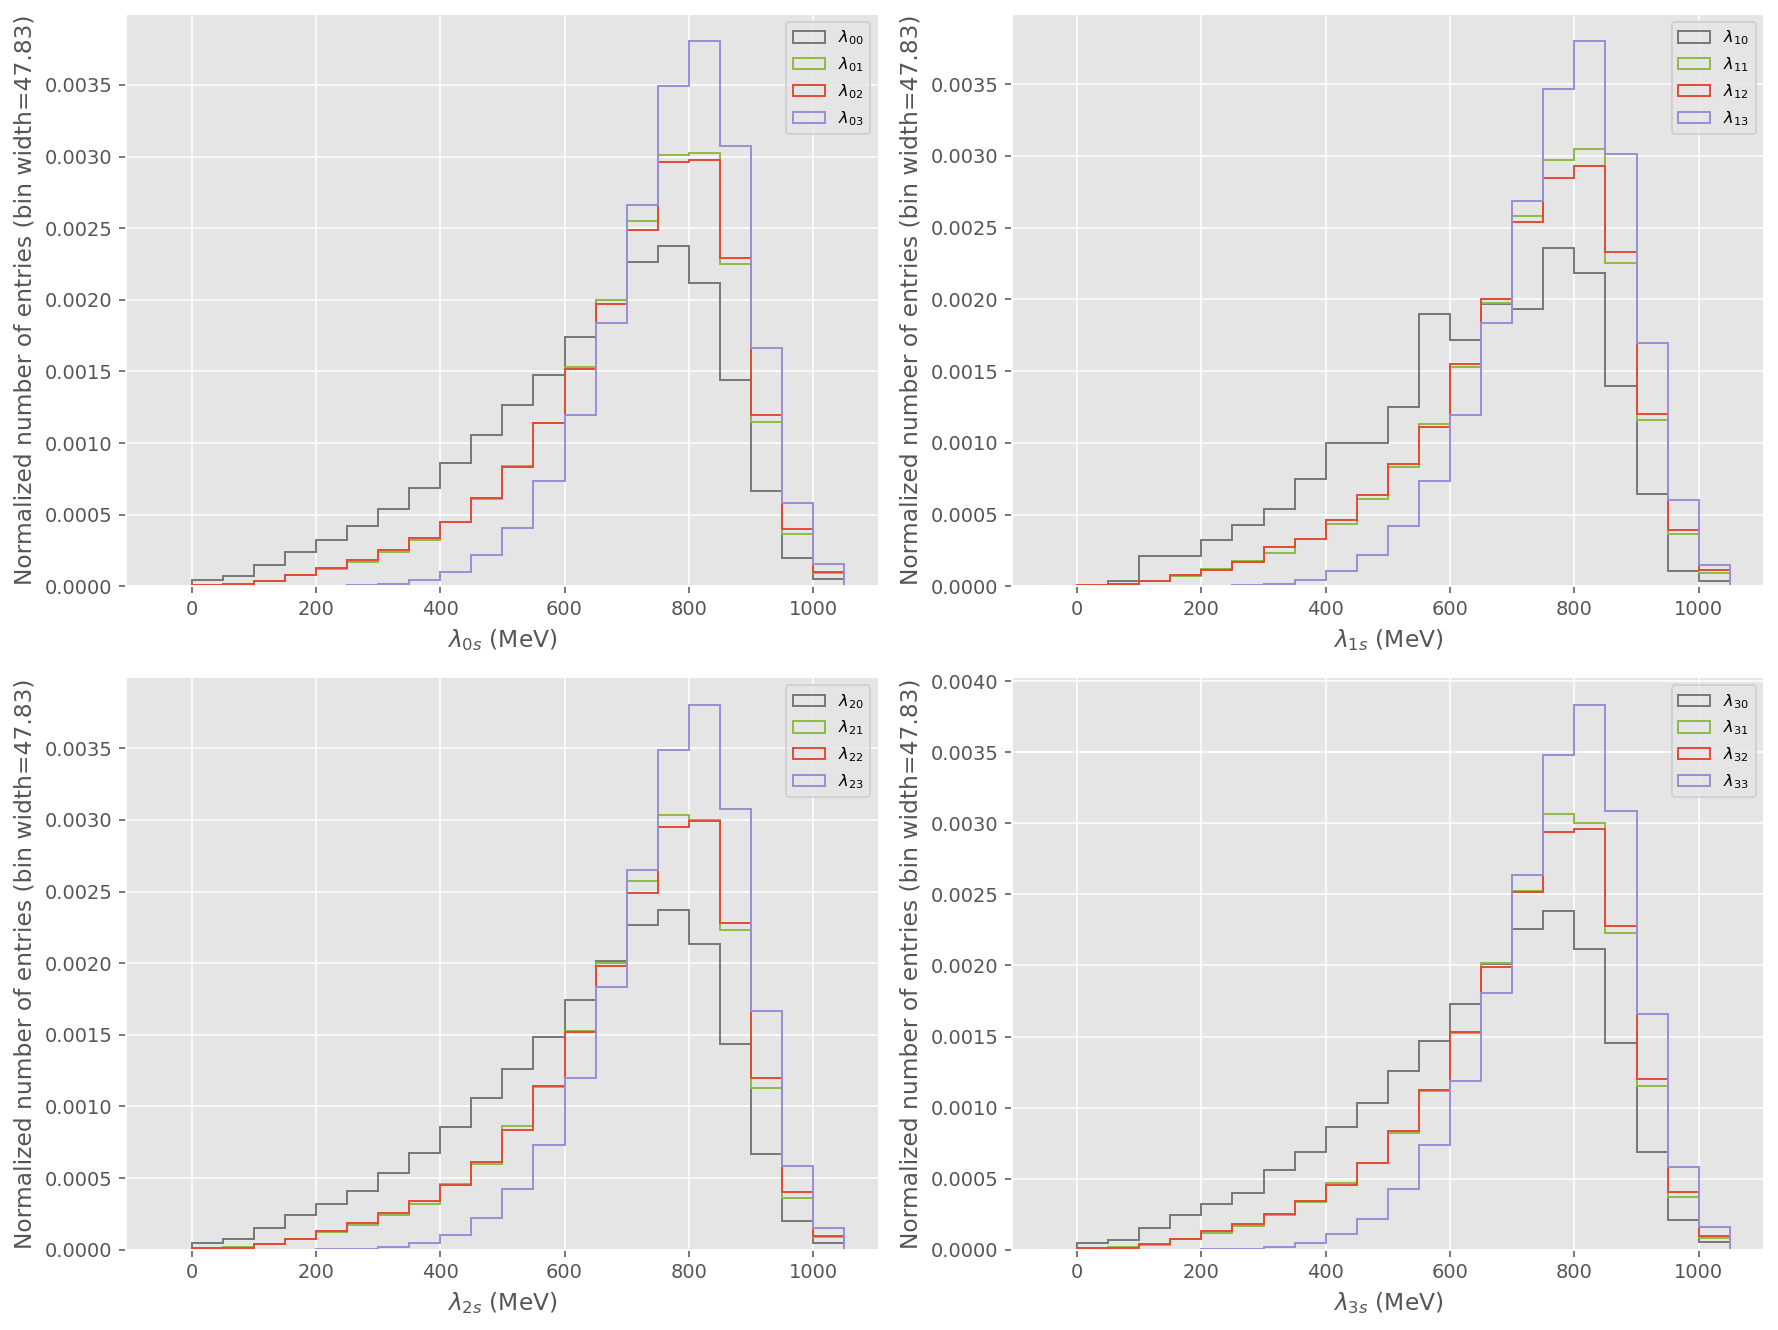

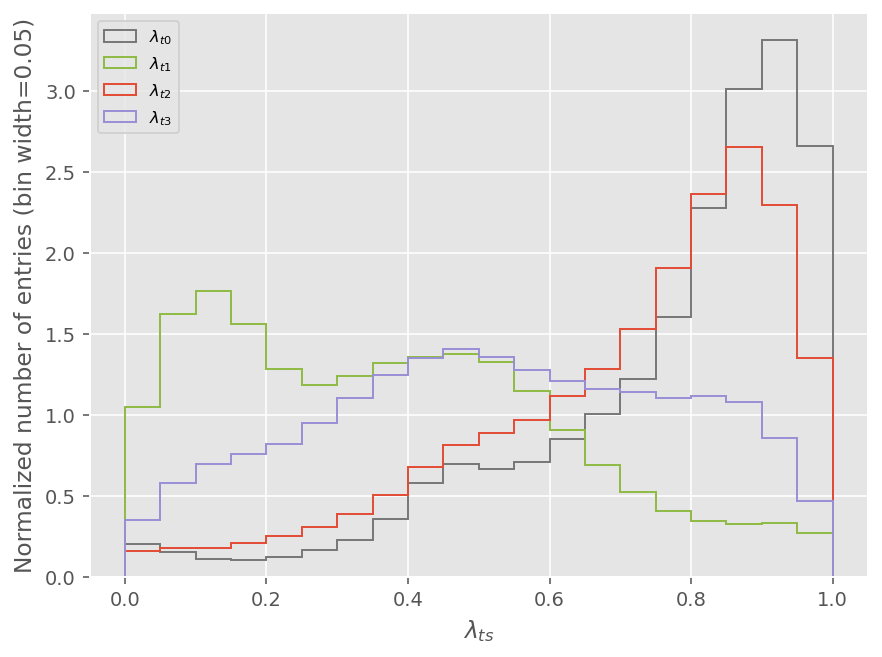

In [3]:
pdf = Plots.PlotBook("fit_templates.pdf", False)

tags = cross_section.Tags.ExclusiveProcessTags(toy_input.truth_regions)
for j, c in Plots.IterMultiPlot(templates_energy):
    for i, s in enumerate(c):
        Plots.PlotHist(energy_slice.pos[:-1], energy_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{{j}{i}}}$", xlabel = f"$\lambda_{{{j}s}}$ (MeV)", histtype = "step", newFigure = False, density = True)
pdf.Save()

plt.figure()
for i, s in enumerate(tempalates_mean_track_score):
    Plots.PlotHist(bin_centers(mean_track_score_bins), mean_track_score_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{t{i}}}$", xlabel = f"$\lambda_{{ts}}$", histtype = "step", newFigure = False, density = True)
plt.legend(loc = "upper left")
pdf.Save()
pdf.close()

# Validation test

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(7900216, 7900216.000000003, 8409.27007314209)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  1.000000  1.000000  1.000000  1.000000
error  0.002198  0.003086  0.002289  0.005516

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


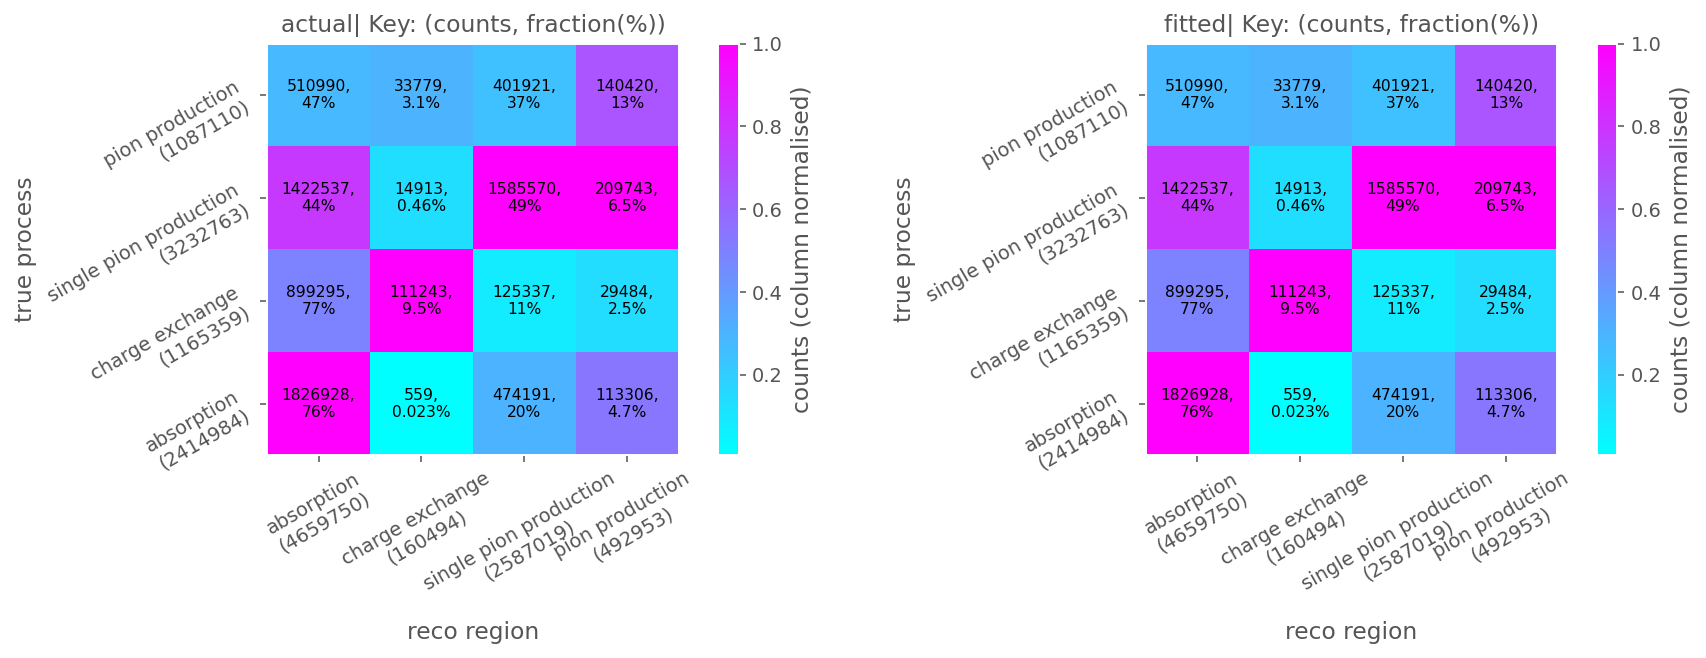

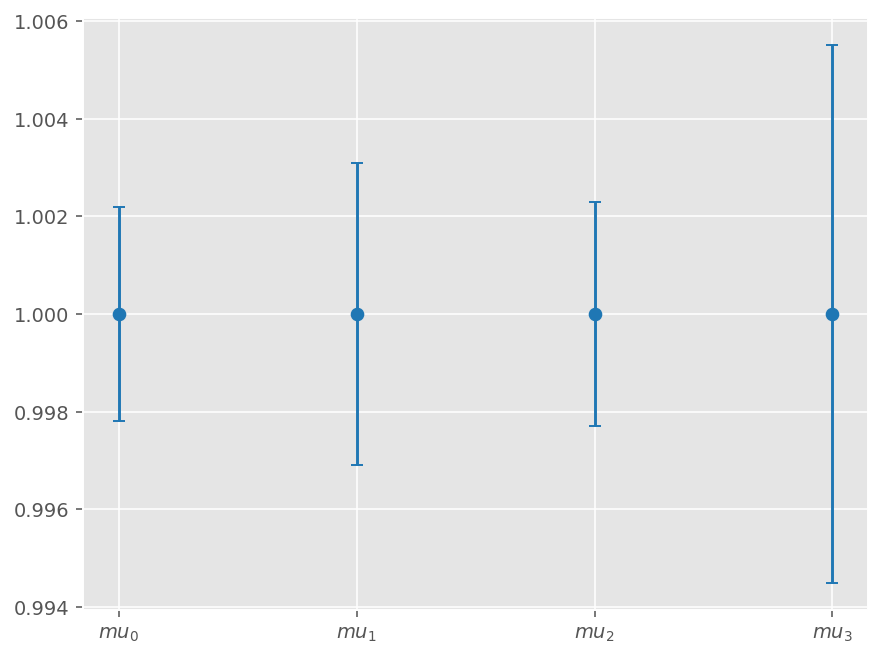

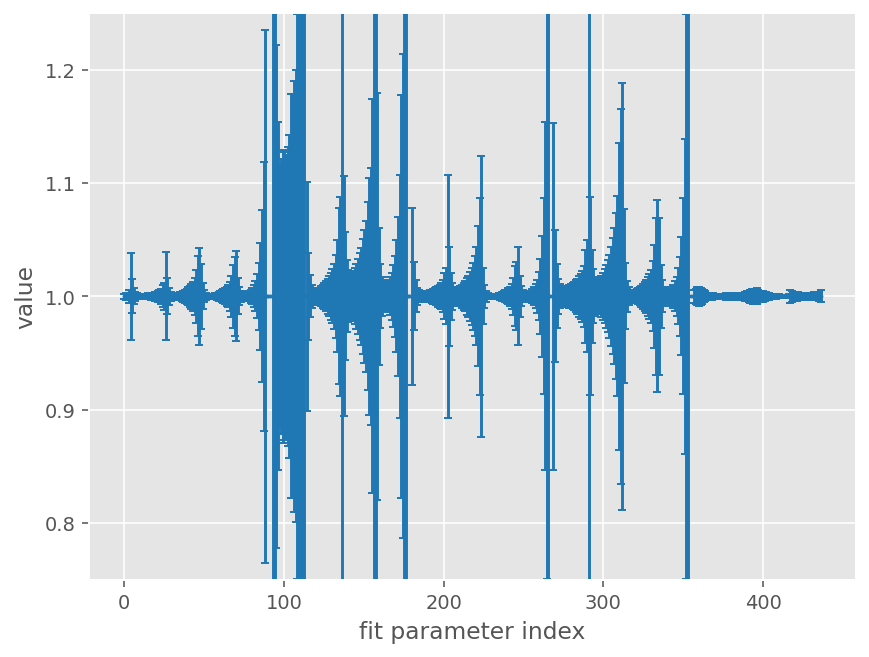

In [34]:
pdf = Plots.PlotBook("toy_validation_fit", False)
result = RegionFitToyStudy(toy_input, model, energy_slice, mean_track_score_bins, pdf = pdf)
pdf.close()

# ProtoDUNE MC Stats

In [14]:
def randint(n : int, length : int = 10):
    min = 10**(length-1)
    max = 9*min + (min-1)
    return np.random.randint(min, max, n)


def RandomSampleToy(n : int, path : str = None, df : pd.DataFrame = None, seed : int = None):
    if (path is not None) and (df is None):   
        with pd.HDFStore(path) as store:
            n_rows = store.get_storer("df").nrows
        tmp = pd.read_hdf(path, where = pd.Index(np.random.choice(range(n_rows), n)))
    elif (df is not None) and (path is None):
        tmp = df.sample(n, random_state = seed)
    elif (df is not None) and (path is not None):
        raise Exception("Either path or df must be provided, not both.")
    else:
        raise Exception("path or df must be specified")
    return tmp

# RandomSampleToy(50805, "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_20M.hdf5")

In [4]:
toy_pulls = pd.read_hdf("work/2023/toys/xs_toy_1GeV_gaussian_60MeV_20M_fast_2.hdf5")

In [9]:
def Run(n : int, seed : int):
    toy = cross_section.Toy(df = RandomSampleToy(int(n), df = toy_pulls, seed = seed), smearing = True)
    puller = Pulls(toy, model, energy_bins)
    clear_output()
    return puller.ComputePulls()

def CalculatePulls(n_exp : int, n_events : int, n_cpus : int = 10):
    pool = cex_toy_generator.ProcessPool(nodes = n_cpus)
    workers = []

    seeds = randint(n_exp, length = 9)

    for i in range(n_exp):
        clear_output()
        workers.append(pool.apipe(Run, n_events, seeds[i]))
    results = [worker.get() for worker in workers]
    pool.clear()
    pool.restart()
    return np.array(results)

cross_section.SaveSelection("pulls_5E6_alt_3.dill", CalculatePulls(100, 5E6, 4))

'CreateObservedInputData' executed in 2.0875s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

'CreateObservedInputData' executed in 2.1166s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

'CreateObservedInputData' executed in 0.9039s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

'CreateObservedInputData' executed in 0.6197s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

pulls_5E6.dill

\begin{tabular}{lrrrr}
 & mu & sigma & z & p \\
$\mu_0$ & 3.452794 & 0.581196 & 59.110681 & 0.000000 \\
$\mu_1$ & -2.560546 & 0.648970 & -39.257783 & 0.000000 \\
$\mu_2$ & -1.345290 & 0.546450 & -24.495323 & 0.000000 \\
$\mu_3$ & 0.499779 & 0.586110 & 8.484300 & 0.000000 \\
\end{tabular}

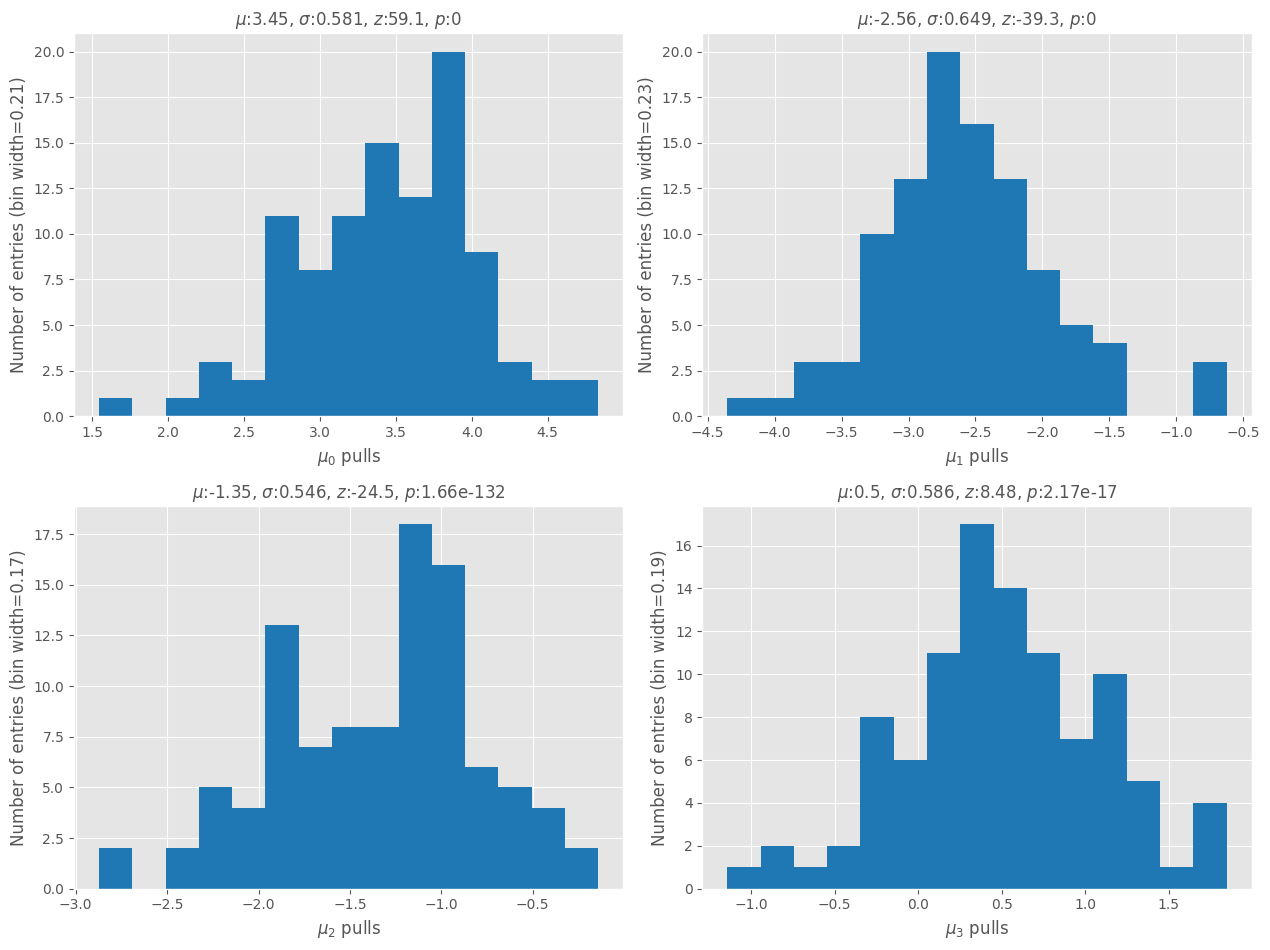

pulls_5E6_2.dill

\begin{tabular}{lrrrr}
 & mu & sigma & z & p \\
$\mu_0$ & 3.373850 & 0.638204 & 52.599741 & 0.000000 \\
$\mu_1$ & -2.503054 & 0.661032 & -37.676059 & 0.000000 \\
$\mu_2$ & -1.246788 & 0.597755 & -20.753294 & 0.000000 \\
$\mu_3$ & 0.413882 & 0.677585 & 6.077577 & 0.000000 \\
\end{tabular}

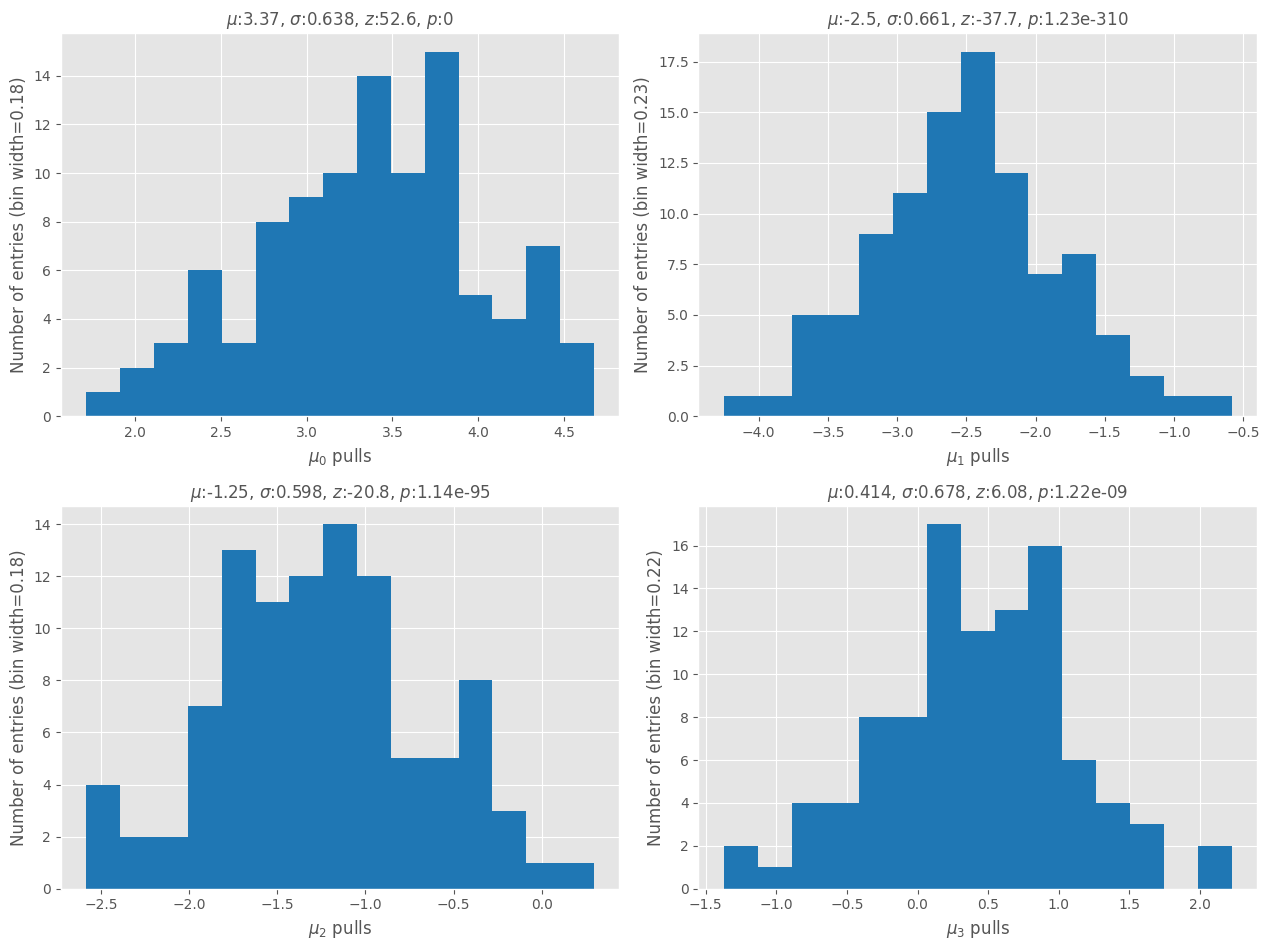

pulls_5E6_alt.dill

\begin{tabular}{lrrrr}
 & mu & sigma & z & p \\
$\mu_0$ & 1.757822 & 0.629084 & 27.802518 & 0.000000 \\
$\mu_1$ & -0.904344 & 0.704939 & -12.764381 & 0.000000 \\
$\mu_2$ & 0.989191 & 0.642534 & 15.317980 & 0.000000 \\
$\mu_3$ & -1.868511 & 0.680950 & -27.302236 & 0.000000 \\
\end{tabular}

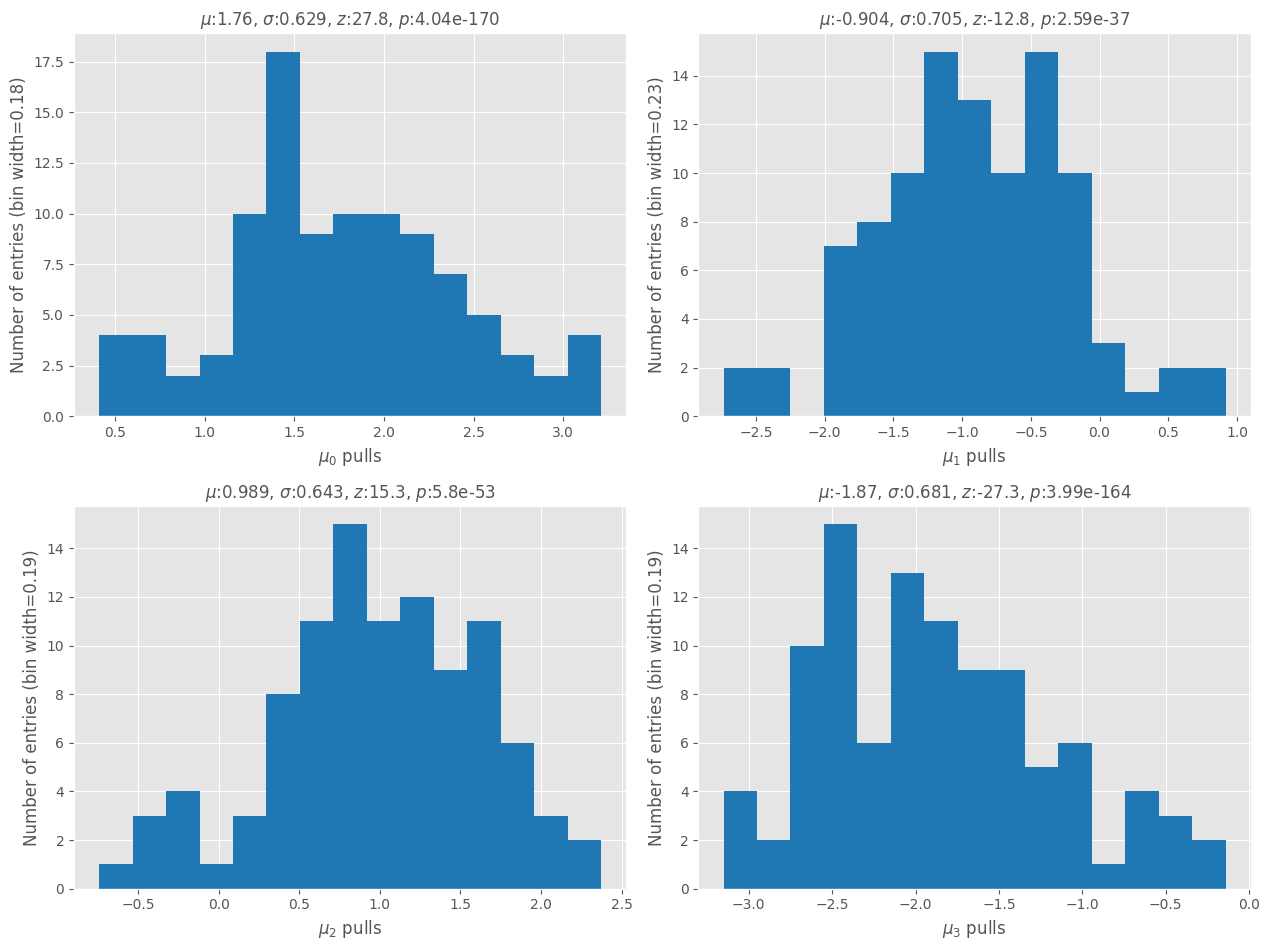

pulls_5E6_alt_2.dill

\begin{tabular}{lrrrr}
 & mu & sigma & z & p \\
$\mu_0$ & 1.734467 & 0.651387 & 26.493804 & 0.000000 \\
$\mu_1$ & -0.979548 & 0.677694 & -14.381690 & 0.000000 \\
$\mu_2$ & 1.088378 & 0.651936 & 16.610867 & 0.000000 \\
$\mu_3$ & -1.913696 & 0.676045 & -28.165341 & 0.000000 \\
\end{tabular}

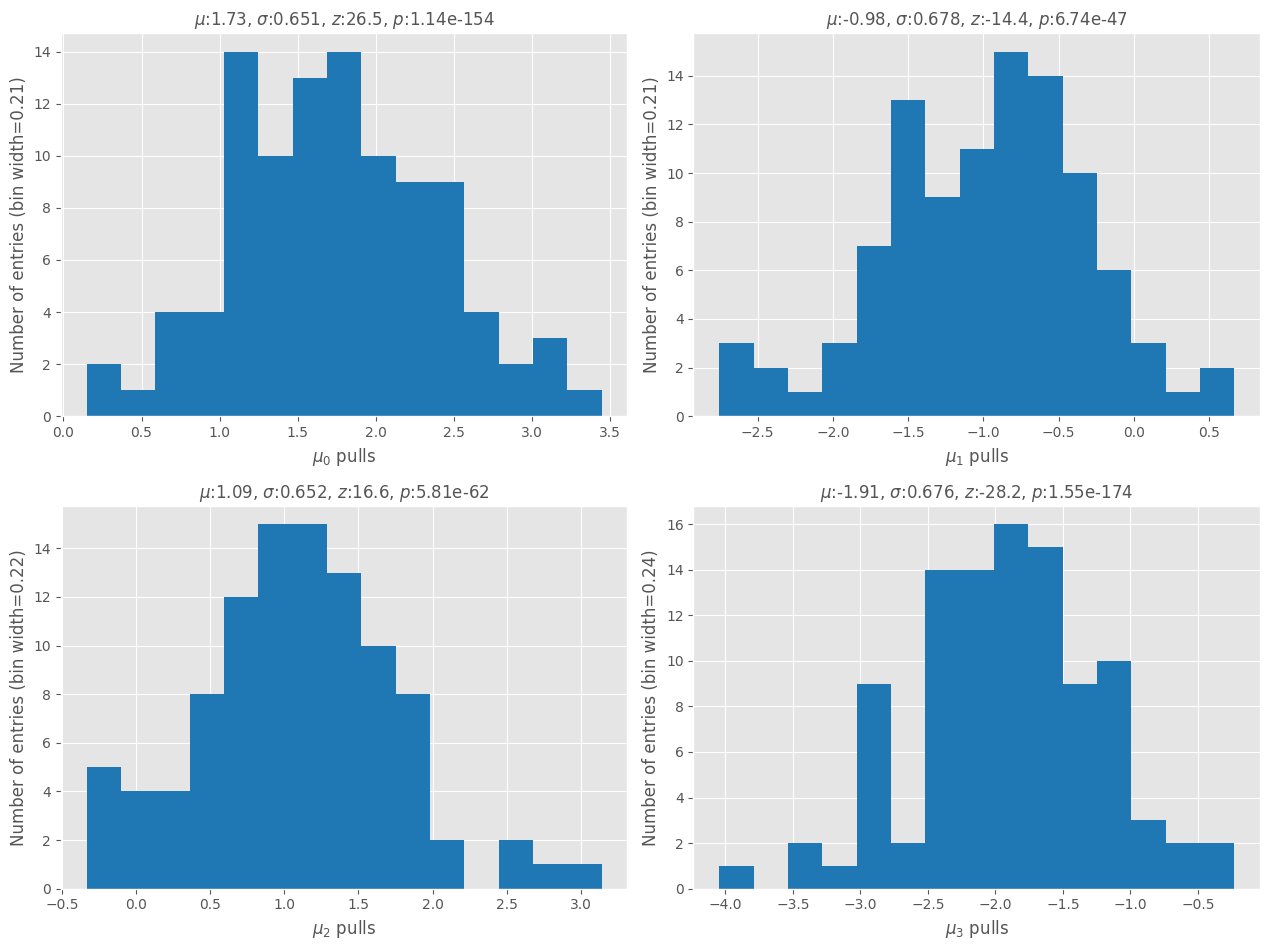

pulls_5E6_alt_3.dill

\begin{tabular}{lrrrr}
 & mu & sigma & z & p \\
$\mu_0$ & 1.652056 & 0.590902 & 27.818047 & 0.000000 \\
$\mu_1$ & -0.972705 & 0.648858 & -14.915896 & 0.000000 \\
$\mu_2$ & 1.153204 & 0.632106 & 18.152381 & 0.000000 \\
$\mu_3$ & -1.927585 & 0.650604 & -29.479131 & 0.000000 \\
\end{tabular}

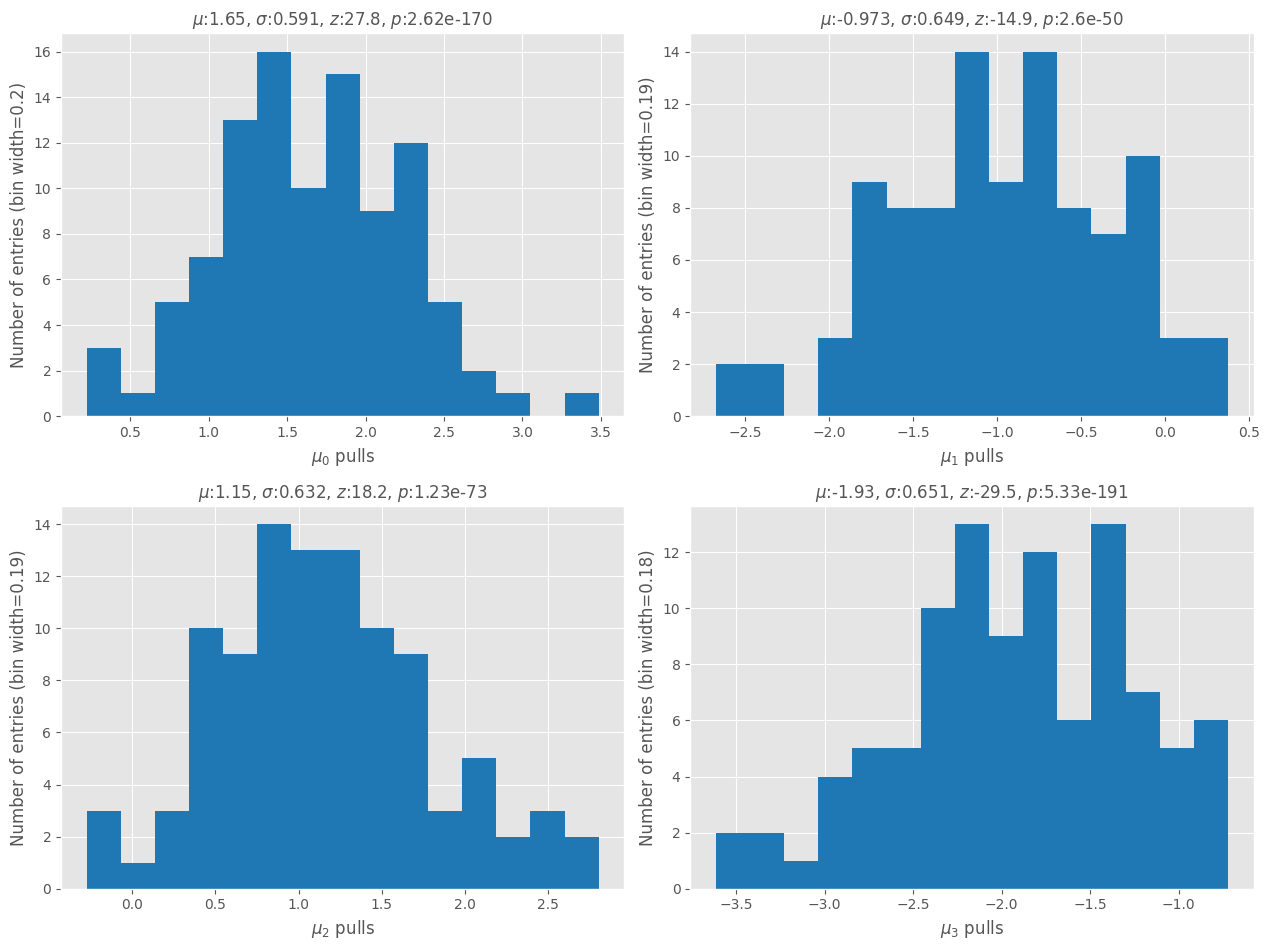

In [10]:
# ["pulls_1E4.dill", "pulls_5E4.dill", "pulls_1E5.dill", "pulls_5E5.dill", "pulls_1E6.dill", "pulls_5E6.dill"]
for p in ["pulls_5E6.dill", "pulls_5E6_2.dill", "pulls_5E6_alt.dill", "pulls_5E6_alt_2.dill", "pulls_5E6_alt_3.dill"]:
    print(p)
    pulls = cross_section.LoadSelectionFile(p)
    pulls = np.array([i for i in pulls if len(i) == 4])
    StudyPulls(pulls)
    plt.show()

In [38]:
toy_PDSP_1GeV_config = {
    "events" : 50805,
    "step" : 2,
    "p_init" : 1000,
    "beam_profile" : "gaussian",
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_ff_resolution.json",
        "KE_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int_resolution.json",
        "z_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/track_length_resolution.json"
    },
    "reco_region_fractions" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : None,
    "df_format" : "f",
    "blur_strengths" : None,
    "verbose" : False
}

In [39]:
toy_observed = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(toy_PDSP_1GeV_config)), smearing = True)

starting batch : 0, cpus : 11

starting batch : 1, cpus : 11

starting batch : 2, cpus : 11

starting batch : 3, cpus : 11

starting batch : 4, cpus : 7

'Smearing' executed in 0.1079s

'BeamSelectionEfficiency' executed in 0.0065s

'GenerateRecoRegions' executed in 0.0725s

'MeanTrackScore' executed in 0.3785s

'main' executed in 4.4701s

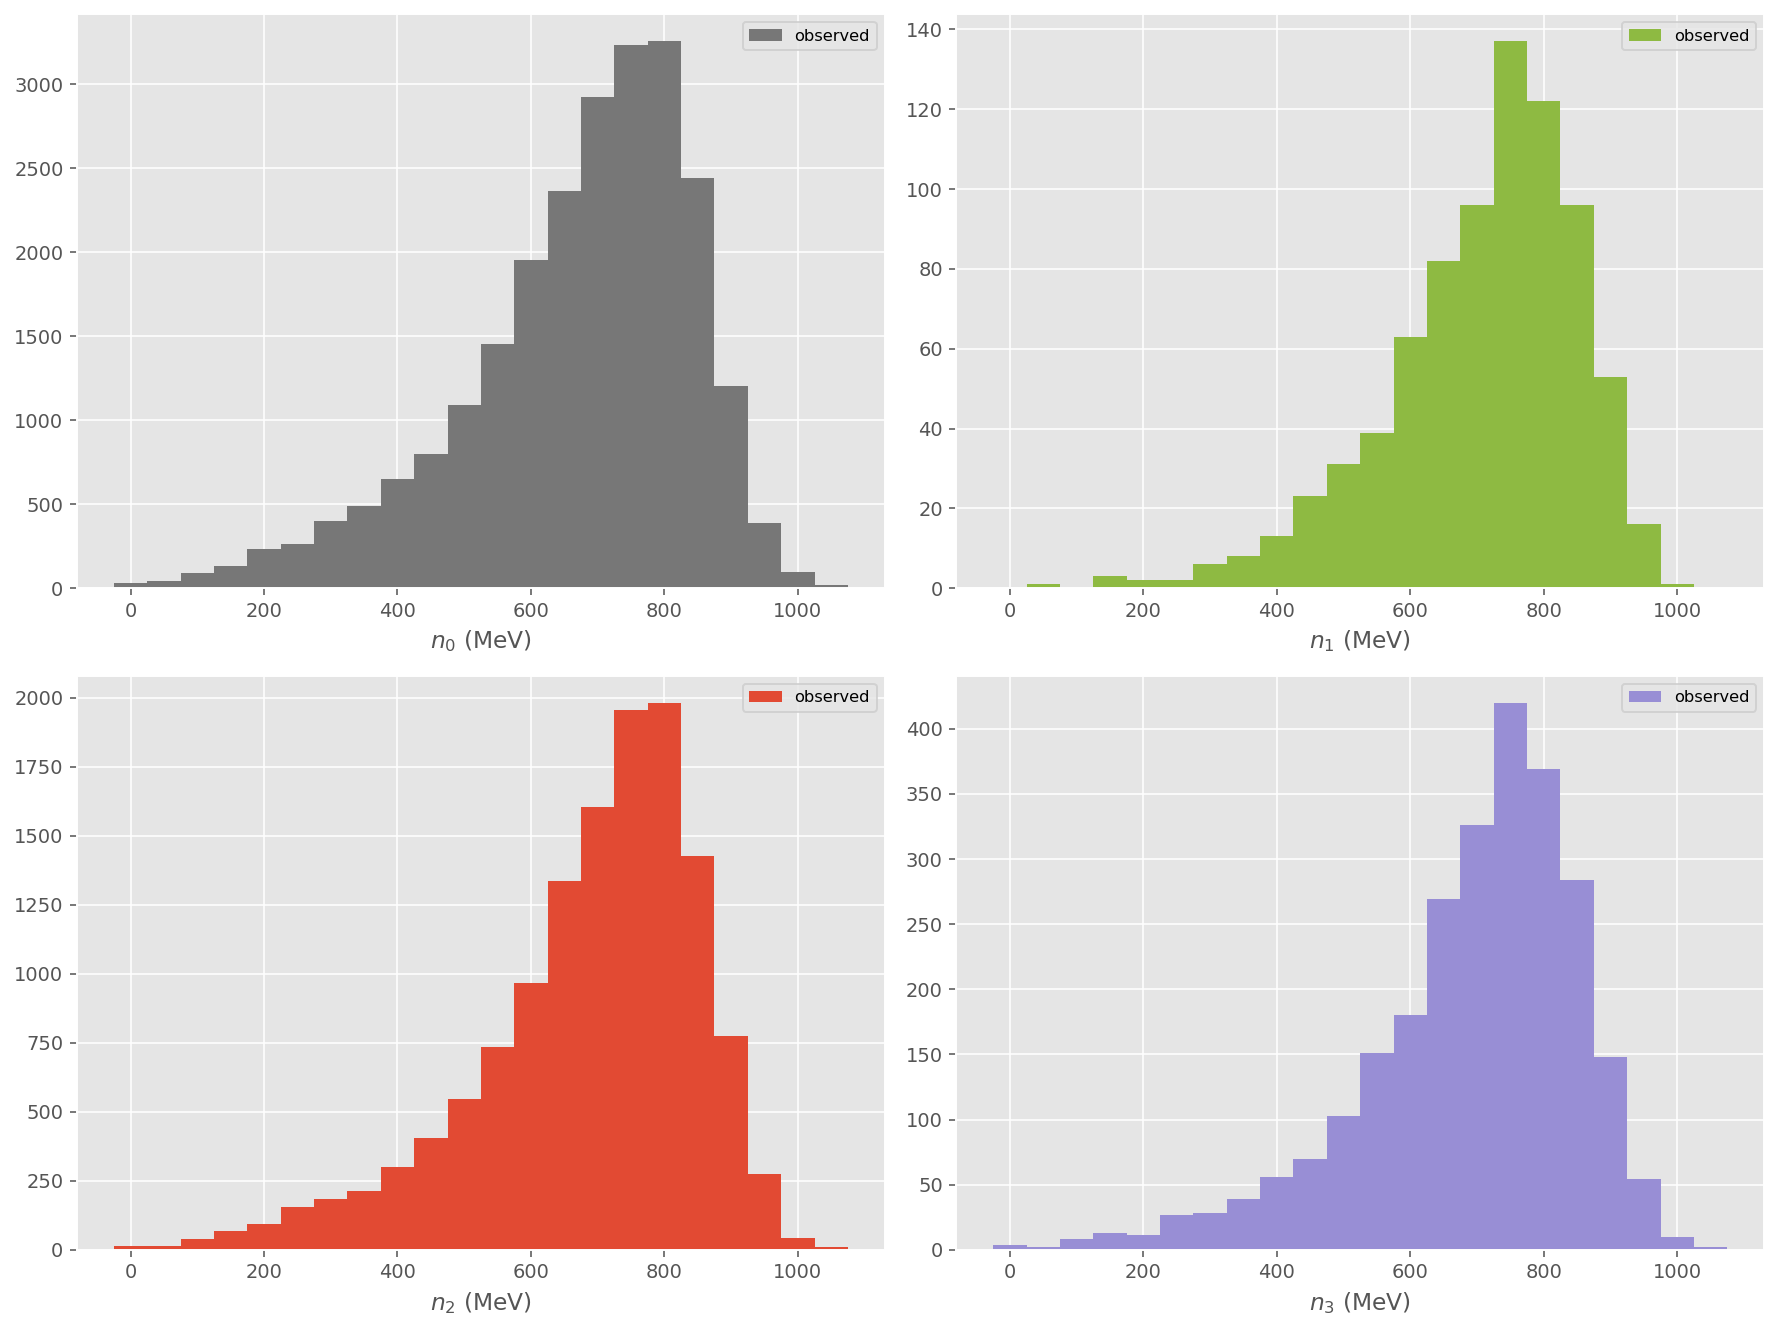

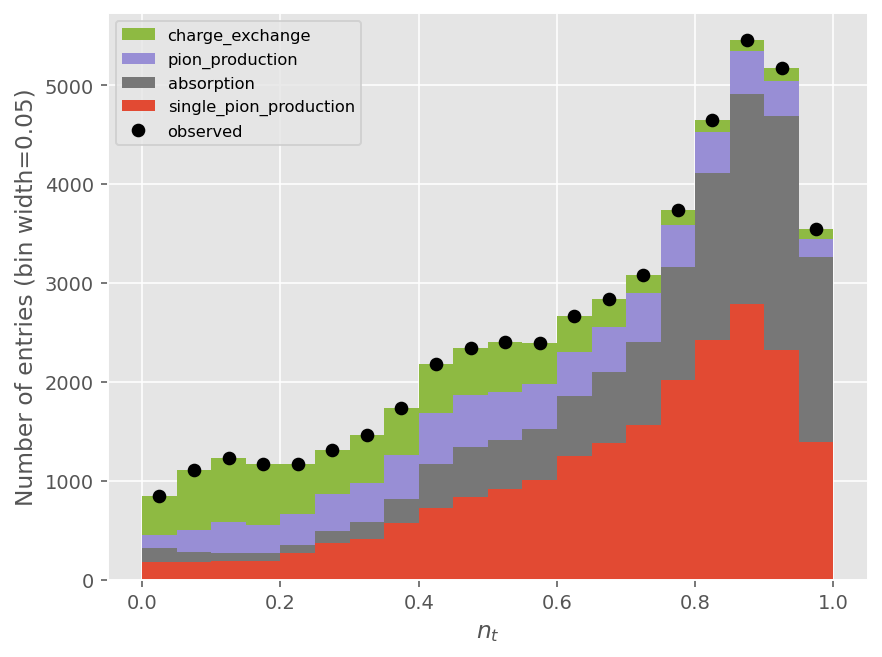

In [40]:
pdf = Plots.PlotBook("toy_observations.pdf", False)
tags = cross_section.Tags.ExclusiveProcessTags(toy_observed.truth_regions)

n_obs = cross_section.RegionFit.CreateObservedInputData(cross_section.RegionFit.CreateFitInputToy(toy_observed), energy_slice, mean_track_score_bins)
n_obs_energy = n_obs[:-1]
n_obs_mean_track_score = n_obs[-1]
for i, r in Plots.IterMultiPlot(toy_observed.reco_region_labels):
    # Plots.PlotTagged(toy_observed.df.KE_int_smeared[toy_observed.reco_regions[r]], cross_section.Tags.ExclusiveProcessTags(toy_observed.truth_regions), energy_bins, newFigure = False)
    # Plots.PlotHist(bin_centers(energy_bins), energy_bins, weights = n_obs_energy[i], label = "observed", histtype = "step", color = "black", newFigure = False)
    Plots.Plot(energy_slice.pos[:-1], n_obs_energy[i], xlabel = f"$n_{{{i}}}$ (MeV)", marker = "o", color = tags[r].colour, linestyle = "-", label = "observed", style = "bar", newFigure = False)
pdf.Save()

Plots.PlotTagged(toy_observed.df.mean_track_score, tags, mean_track_score_bins)
Plots.Plot(bin_centers(mean_track_score_bins), n_obs_mean_track_score, xlabel = "$n_{t}$", marker = "o", color = "black", linestyle = "", label = "observed", newFigure = False)
pdf.Save()
pdf.close()

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(40058, 40072.99849625984, 503.2198962696118)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.004962  0.004941  0.005026  0.005596
error  0.000126  0.000186  0.000141  0.000352

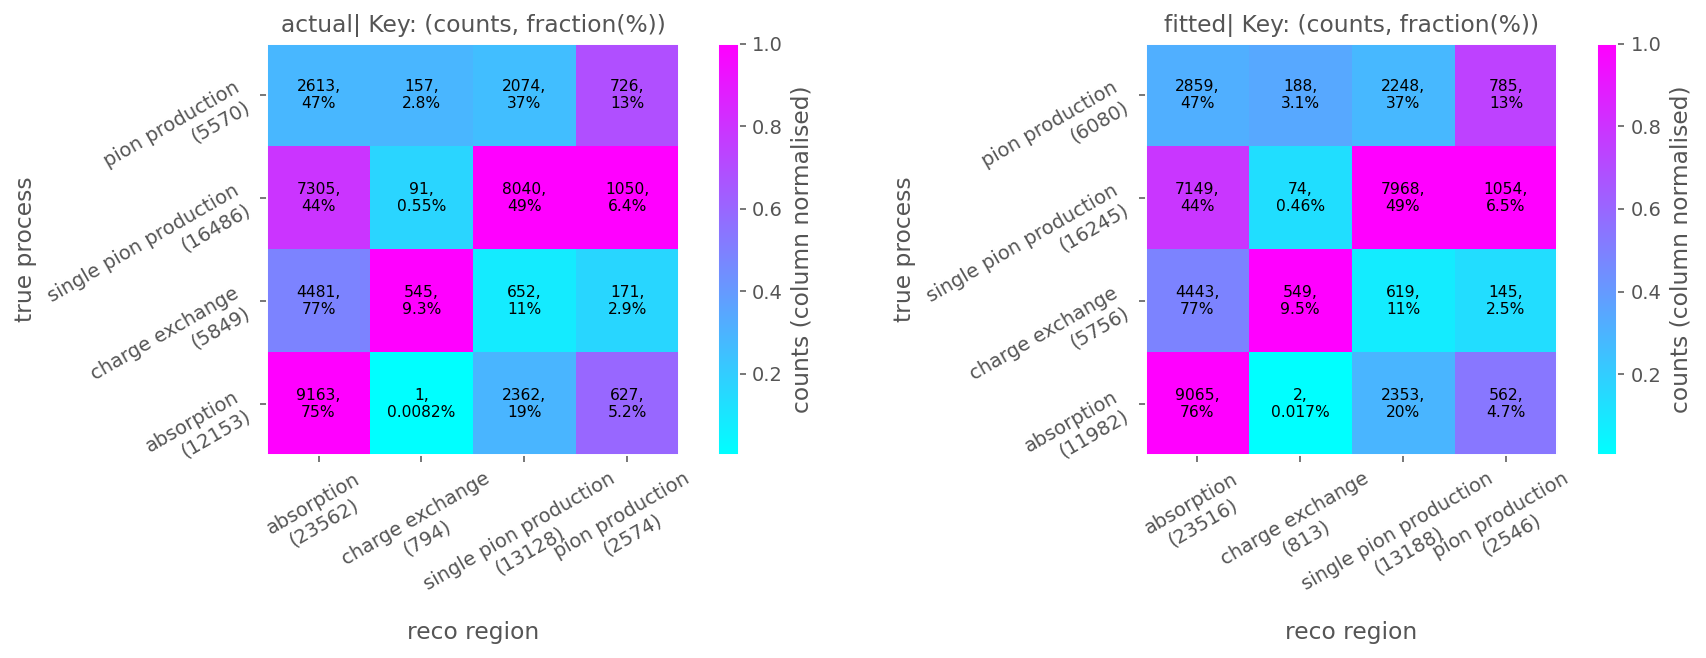

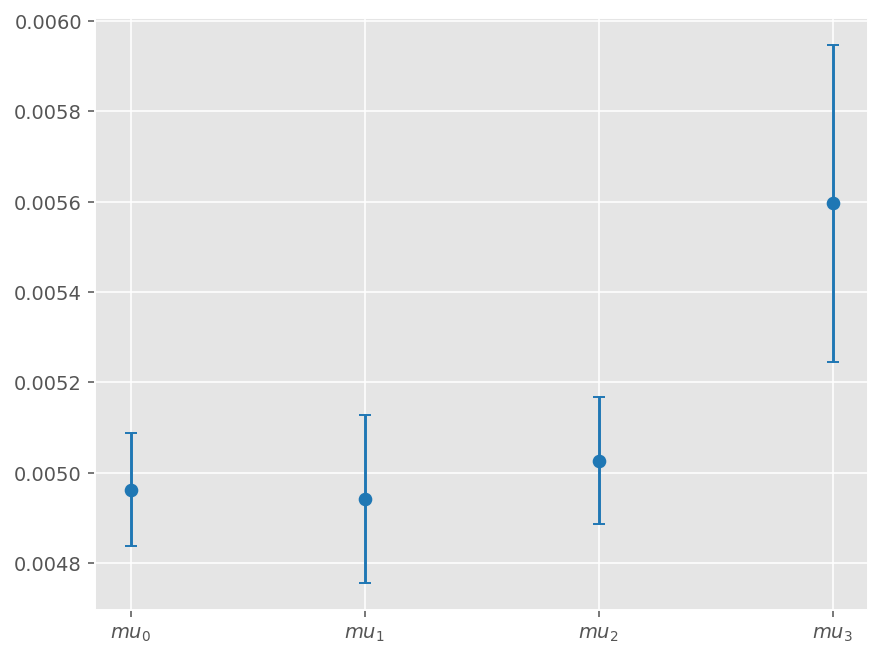

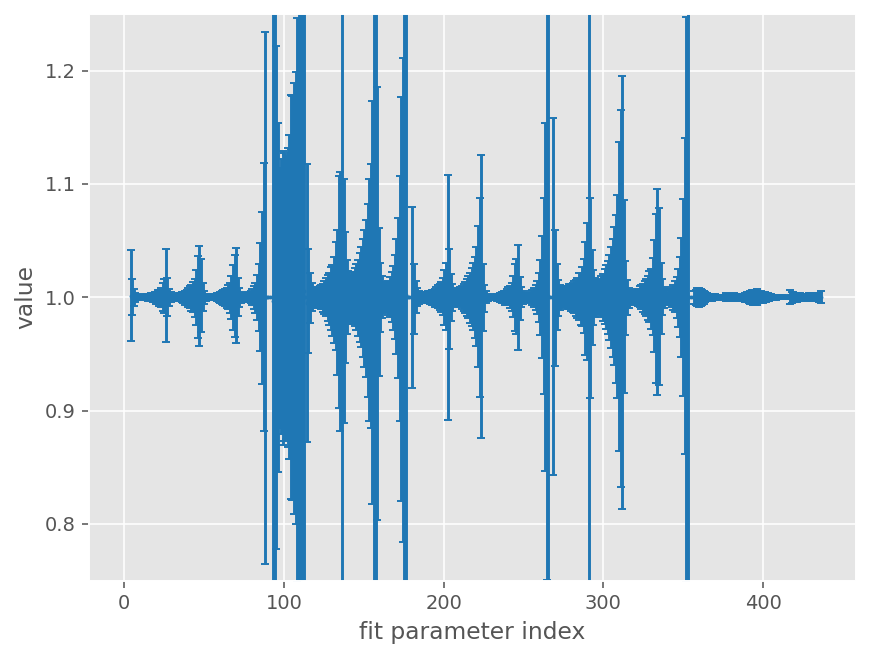

In [41]:
pdf_low_stats = Plots.PlotBook("toy_fit_low_stats.pdf", False)
result = RegionFitToyStudy(toy_observed, model, energy_slice, mean_track_score_bins, pdf = pdf_low_stats)
pdf_low_stats.close()

# Alternate correlation matrix

In [28]:
toy_alt = cross_section.Toy("work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", True)
fractions = pd.read_hdf("work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5")

print(fractions)

fractions["pion_production"]["pion_production"] += 0.25
fractions["pion_production"]["single_pion_production"] -= 0.25

# fractions["charge_exchange"]["charge_exchange"] += 0.1
# fractions["charge_exchange"]["absorption"] -= 0.1


print(fractions)

regions = cex_toy_generator.GenerateRecoRegions(toy_input.df.exclusive_process, fractions)

toy_alt._Toy__reco_regions = cross_section.Toy.GetRegion(regions, "reco_regions_")
toy_alt._Toy__truth_regions = cross_section.Toy.GetRegion(regions, "truth_regions_")


absorption  charge_exchange  single_pion_production  \
absorption                0.756340         0.771416                0.440383   
charge_exchange           0.000238         0.095566                0.004684   
single_pion_production    0.196333         0.107476                0.489869   
pion_production           0.047089         0.025542                0.065065   

                        pion_production  
absorption                     0.469713  
charge_exchange                0.031233  
single_pion_production         0.369524  
pion_production                0.129529

absorption  charge_exchange  single_pion_production  \
absorption                0.756340         0.771416                0.440383   
charge_exchange           0.000238         0.095566                0.004684   
single_pion_production    0.196333         0.107476                0.489869   
pion_production           0.047089         0.025542                0.065065   

                        pion_production  
absorption                     0.469713  
charge_exchange                0.031233  
single_pion_production         0.119524  
pion_production                0.379529

'GenerateRecoRegions' executed in 15.2137s

In [29]:
pdf = Plots.PlotBook("toy_vary_regions.pdf", False)
cross_section.Toy.PlotObservablesInRegions(toy_alt.df.KE_int_smeared, toy_alt.reco_regions, toy_alt.truth_regions, "$KE_{int} (MeV)$", stacked = True, histtype = "stepfilled", pdf = pdf)
result = RegionFitToyStudy(toy_alt, model, energy_slice, toy_alt.reco_regions, pdf = pdf)
pdf.close()

AttributeError: 'DataFrame' object has no attribute 'KE_int_smeared'

# Modified exclusive process rates

## original PDFs

'Simulate' executed in 5.0337s

'Smearing' executed in 0.0784s

'BeamSelectionEfficiency' executed in 0.0032s

'GenerateRecoRegions' executed in 0.0492s

'MeanTrackScore' executed in 0.3102s

'main' executed in 5.5760s

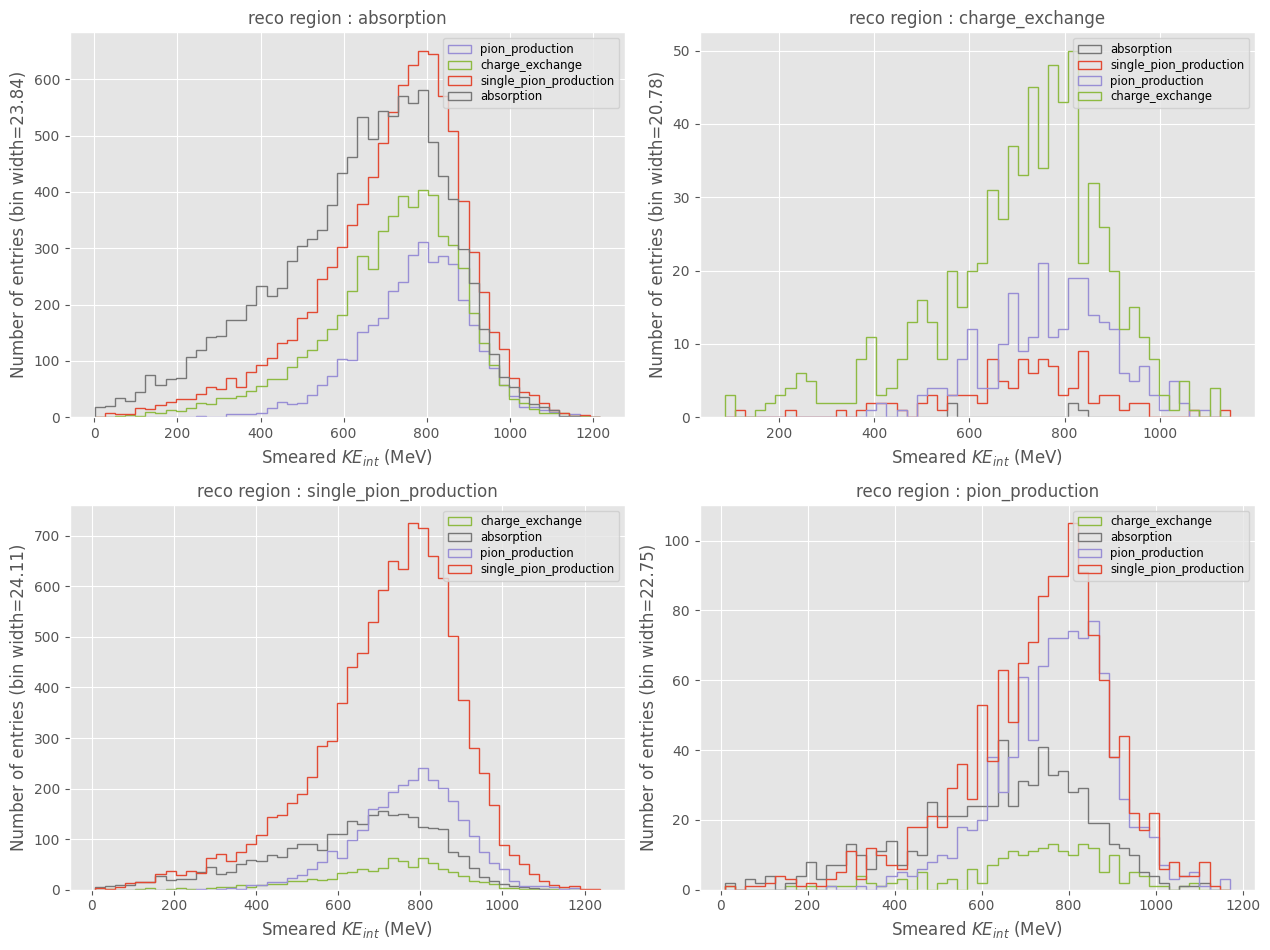

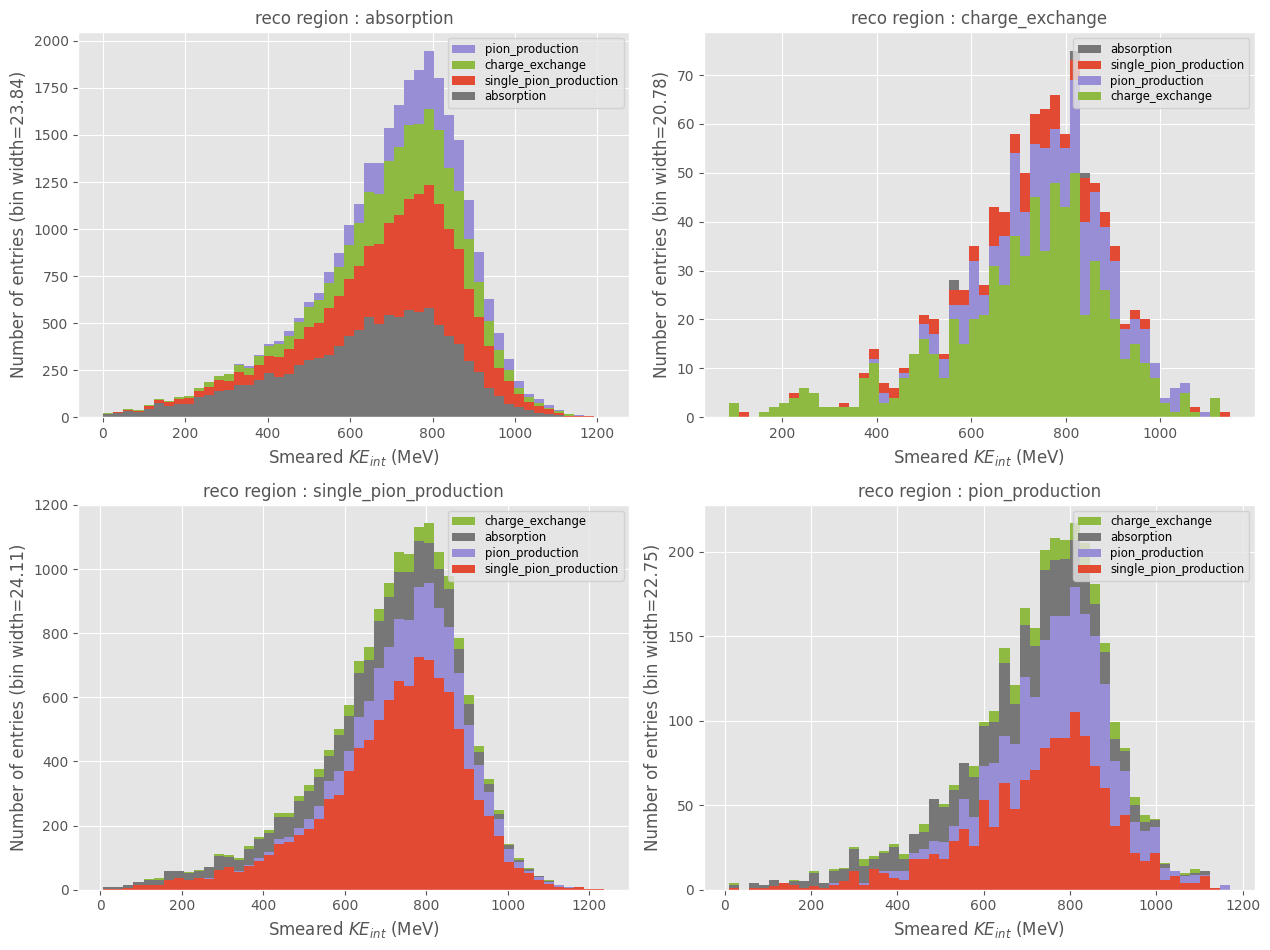

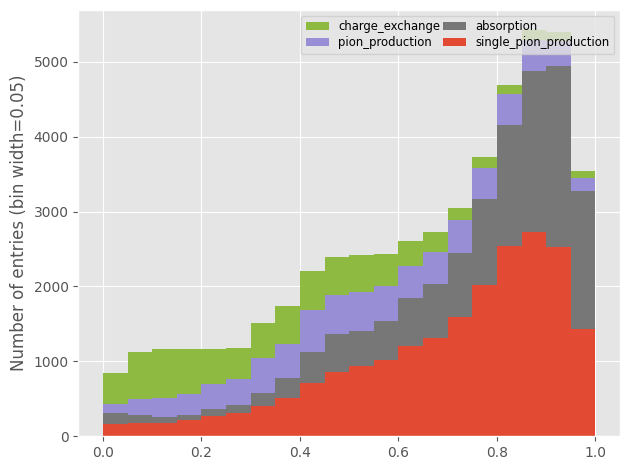

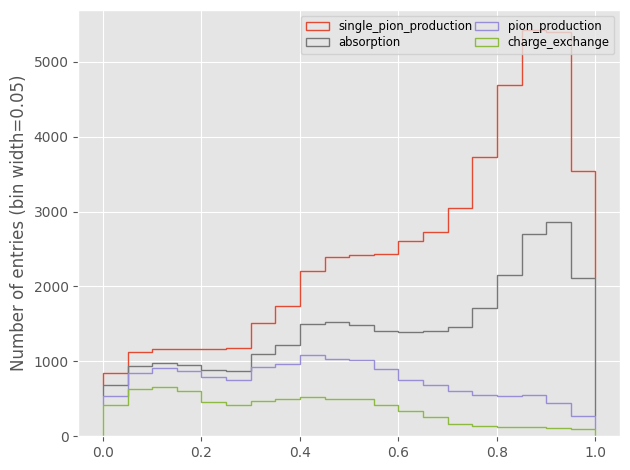

In [42]:
toy_alt_pdf = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(toy_PDSP_1GeV_config)), smearing = True)
cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")
cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)", stacked = True, histtype = "stepfilled")
Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins)
Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins, histtype = "step", reverse_sort = True)

## modified PDFs

'Simulate' executed in 5.0633s

'Smearing' executed in 0.0789s

'BeamSelectionEfficiency' executed in 0.0029s

'GenerateRecoRegions' executed in 0.0540s

'MeanTrackScore' executed in 0.3353s

'main' executed in 5.6332s

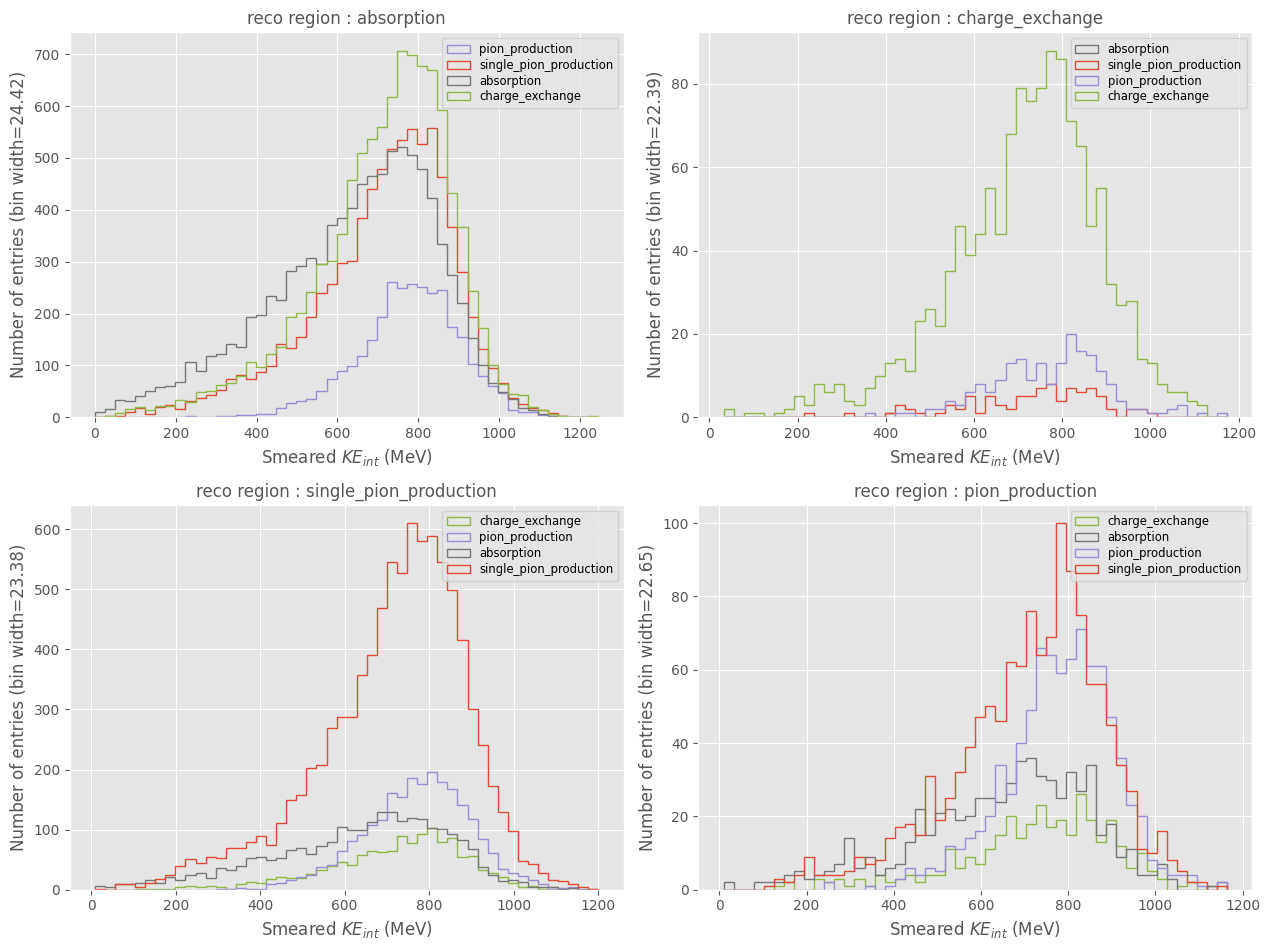

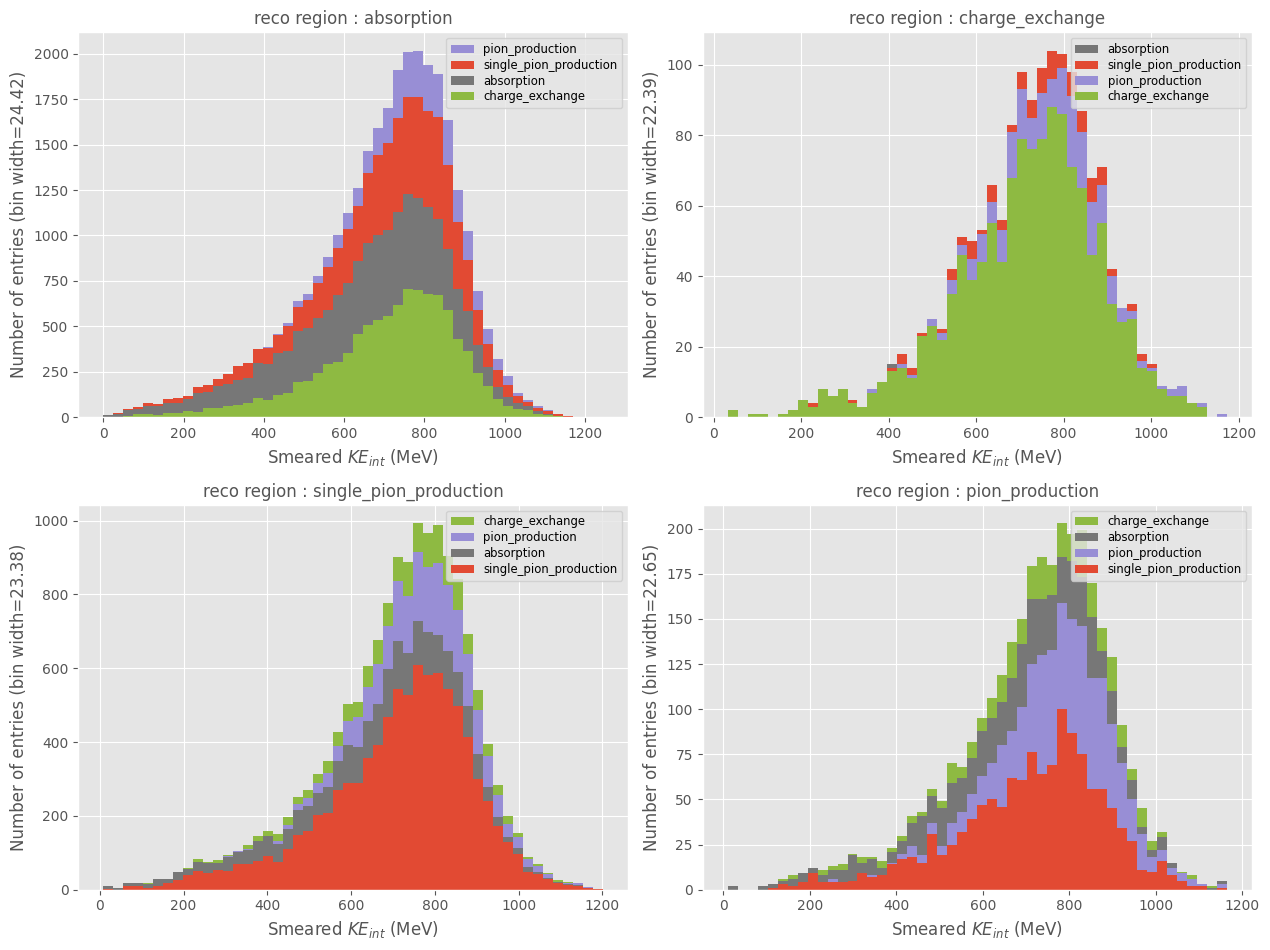

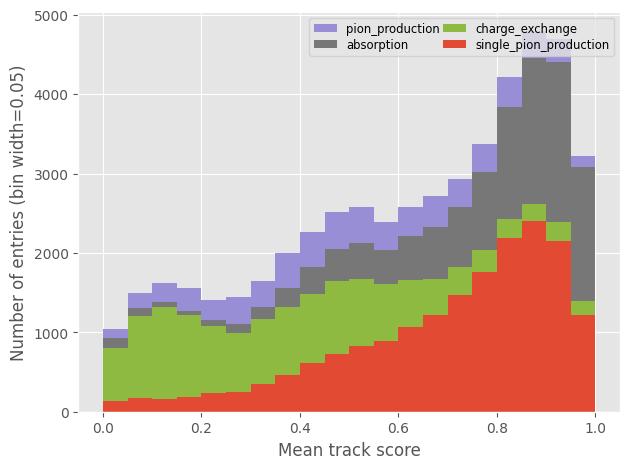

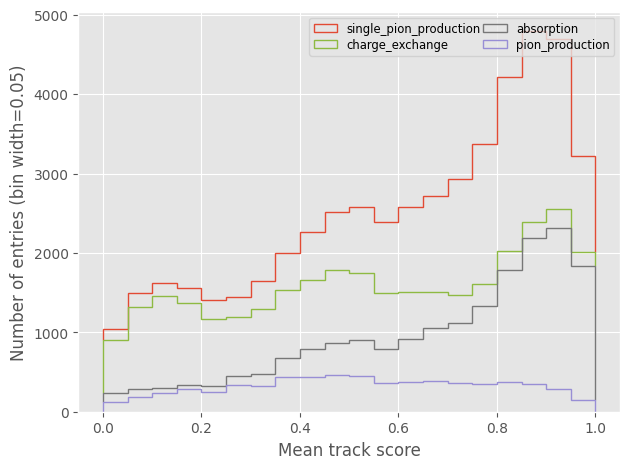

In [43]:
scales = {
    'absorption': 1,
    'quasielastic': 1,
    'charge_exchange': 2,
    'double_charge_exchange': 1,
    'pion_production': 1
    }

toy_alt_pdf = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scales))), smearing = True)
cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")
cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)", stacked = True, histtype = "stepfilled")
Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins, x_label = "Mean track score")
Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins, x_label = "Mean track score", histtype = "step", reverse_sort = True)

## Compare shapes

'Simulate' executed in 4.9744s

'Smearing' executed in 0.0757s

'BeamSelectionEfficiency' executed in 0.0029s

'GenerateRecoRegions' executed in 0.0437s

'main' executed in 5.1894s

'Simulate' executed in 4.8874s

'Smearing' executed in 0.0765s

'BeamSelectionEfficiency' executed in 0.0029s

'GenerateRecoRegions' executed in 0.0452s

'main' executed in 5.1033s

'Simulate' executed in 4.9931s

'Smearing' executed in 0.0770s

'BeamSelectionEfficiency' executed in 0.0028s

'GenerateRecoRegions' executed in 0.0445s

'main' executed in 5.2110s

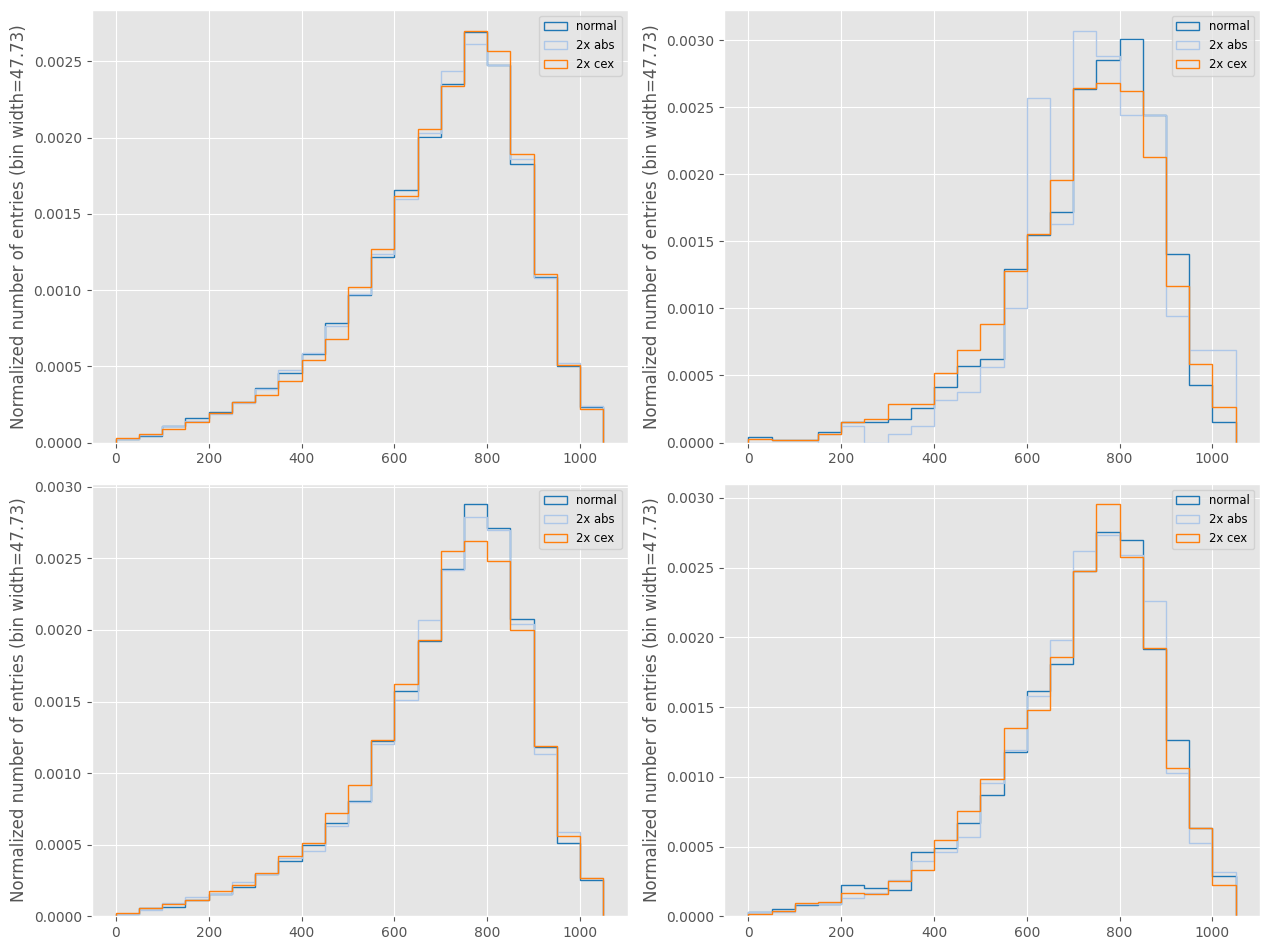

In [31]:
scales_original = {'absorption': 1, 'quasielastic': 1, 'charge_exchange': 1, 'double_charge_exchange': 1, 'pion_production': 1}
scales_abs = {'absorption': 2, 'quasielastic': 1, 'charge_exchange': 1, 'double_charge_exchange': 1, 'pion_production': 1}
scales_cex = {'absorption': 1, 'quasielastic': 1, 'charge_exchange': 2, 'double_charge_exchange': 1, 'pion_production': 1}

toys = [cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(s))), smearing = True) for s in [scales_original, scales_abs, scales_cex]]
for _, r in Plots.IterMultiPlot(toy_input.reco_regions.columns): 
    data = [toy.df.KE_int_smeared[toy.reco_regions[r]] for toy in toys]
    Plots.PlotHistComparison(data, labels = ["normal", "2x abs", "2x cex"], bins = energy_bins, newFigure = False)

## Fits for different rates

In [8]:
def PlotFitResults(results, true_counts, target : str, pdf : Plots.PlotBook = None):
    colours = {
        "absorption"      : "#777777",
        "charge_exchange" : "#8EBA42",
        "single_pion_production" : "#E24A33",
        "pion_production" : "#988ED5",
    }

    mu = []
    mu_err = []
    for result in results.values():
        mu.append(result.bestfit[0:4])
        mu_err.append(result.uncertainty[0:4])
    mu = np.array(mu)
    mu_err = np.array(mu_err)

    xlabel = f"{target} scale factor"

    # Plot the fit value for each scale factor 
    plt.figure()
    for i in range(4):
        Plots.Plot(list(range(len(results))), mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{i}$", marker = "o", ylabel = "fit value", color = list(colours.values())[i])
    Plots.plt.xticks(ticks = list(range(len(results))), labels = results.keys())
    Plots.plt.xlabel(xlabel)
    if pdf: pdf.Save()

    # same as above, in separate plots
    for i in Plots.MultiPlot(4):
        Plots.Plot(list(range(len(results))), mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{i}$", marker = "o", xlabel = xlabel, ylabel = "fit value", color = list(colours.values())[i])
    Plots.plt.xticks(ticks = list(range(len(results))), labels = results.keys())
    if pdf: pdf.Save()

    true_counts_pred_res = {}
    true_counts_pred_res_err = {}
    for k, v in results.items():
        post_fit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = v, label = "post-fit")
        # post_fit_pred = SliceModelPrediction(post_fit_pred, slice(-1), "KE_int_postfit") # remove mean track score results
        # print(f"{post_fit_pred.total_stdev_model_channels=}")
        true_counts_pred_res_err[k] = np.sum(post_fit_pred.total_stdev_model_channels, 0)[:-1]
        true_counts_pred_res[k] = {toy_input.truth_region_labels[j] : int(np.sum([post_fit_pred.model_yields[i][j] for i in range(len(toy_input.reco_region_labels))])) - true_counts[k][toy_input.truth_region_labels[j]] for j in range(len(toy_input.truth_region_labels))}

    true_counts = pd.DataFrame(true_counts)
    true_counts_pred_res = pd.DataFrame(true_counts_pred_res)
    true_counts_pred_res_err = pd.DataFrame(true_counts_pred_res_err, index = true_counts_pred_res.index)

    # plot true process residual
    for n, i in Plots.IterMultiPlot(true_counts.index):
        print(n, i)
        Plots.Plot(true_counts_pred_res.columns, true_counts_pred_res.loc[i], yerr = true_counts_pred_res_err.loc[i], title = f"$\mu_{n}$", xlabel = xlabel, ylabel = "predicted counts - true counts", linestyle = "", marker = "o", color = list(colours.values())[n], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
    if pdf: pdf.Save()


def ModifiedRateTest(scales : dict, pdf_name : str = None, pulls : bool = False):
    if pdf_name is not None:
        pdf = Plots.PlotBook(pdf_name)
        pdf.open()
    else:
        pdf = None

    config = CreateConfig(scales)

    toy_alt_pdf = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config)), smearing = True)
    cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")
    if pdf_name is not None: pdf.Save()
    result = RegionFitToyStudy(toy_alt_pdf, model, energy_slice, mean_track_score_bins, pdf = pdf)
    if pdf_name is not None: pdf.close()

    # mask = (toy_alt_pdf.df.KE_int_smeared > 0) & (toy_alt_pdf.df.KE_int_smeared < 1050) & (toy_alt_pdf.df.inclusive_process != "decay")
    # true_process_counts = {v : np.sum(toy_alt_pdf.truth_regions[v] & mask, 0) for v in toy_alt_pdf.truth_regions.columns}

    # true_process_counts = {v : sum(cross_section.EnergySlice.CountingExperiment(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.df.KE_init_smeared, outside_tpc, toy_alt_pdf.truth_regions[v], energy_slice)[0]) }
    true_process_counts = {}
    for v in toy_alt_pdf.truth_regions.columns:
        true_process_counts[v] = sum(toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.truth_regions[v]))
        # n_interact = cross_section.EnergySlice.CountingExperiment(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.df.KE_init_smeared, toy_alt_pdf.outside_tpc_smeared, toy_alt_pdf.truth_regions[v], energy_slice, interact_only = True)
        # true_process_counts[v] = sum(n_interact[:-1])


    expected_mus = [sum(toy_alt_pdf.truth_regions[r]) / sum(toy_input.truth_regions[r]) for r in toy_alt_pdf.truth_regions]

    if pdf_name is not None: Plots.plt.close("all")
    return result, true_process_counts, expected_mus, None


pdf test/region_fit_tests_old/fit_results_pip.pdf has been opened


0 absorption

1 charge_exchange

2 single_pion_production

3 pion_production

pdf test/region_fit_tests_old/fit_results_pip.pdf has been closed


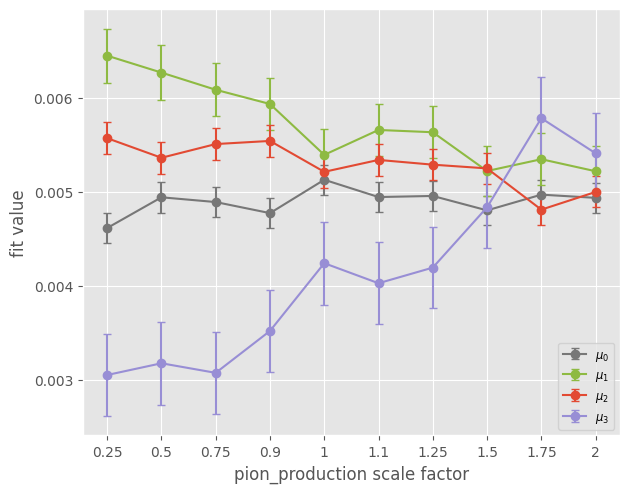

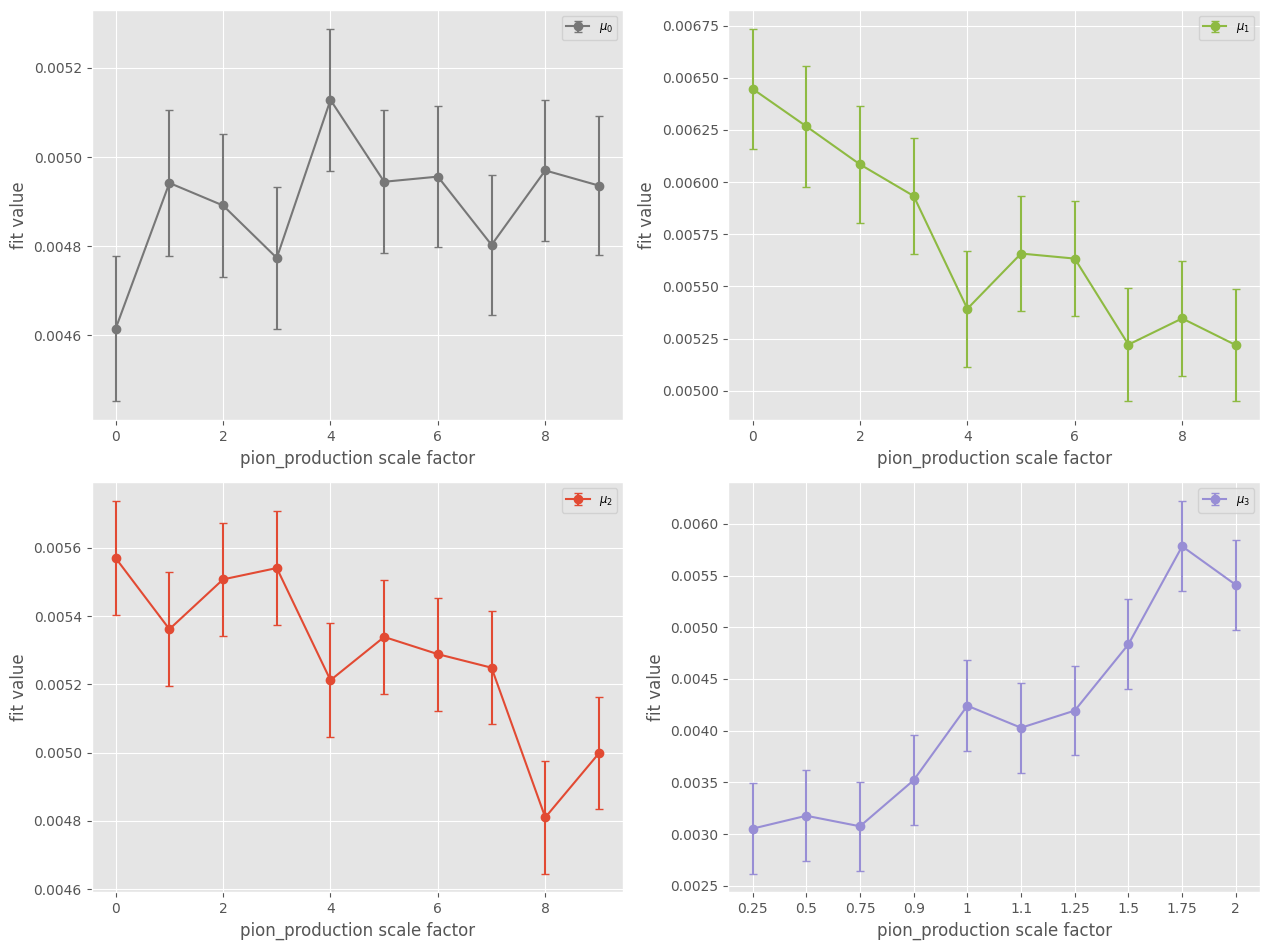

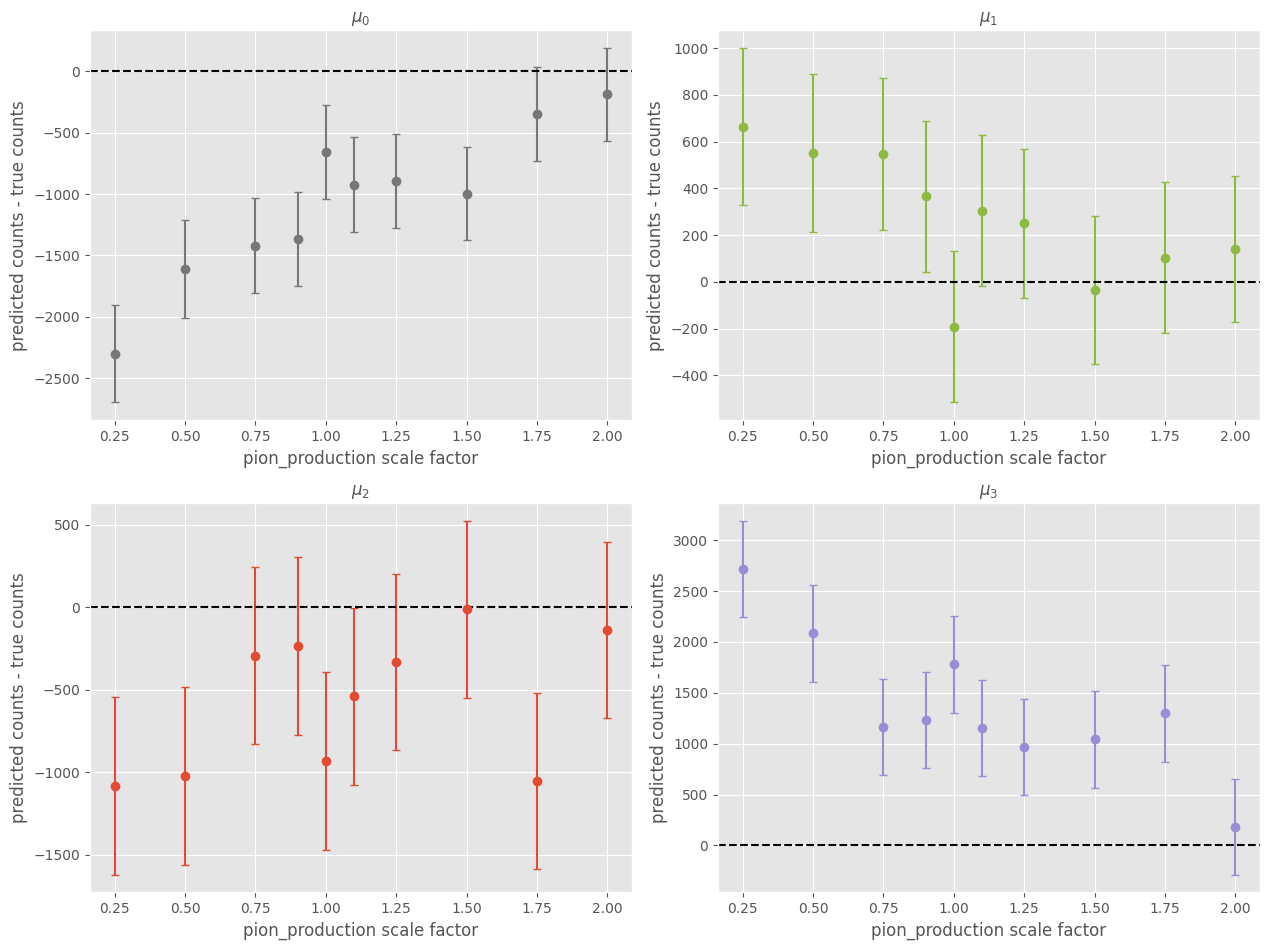

In [9]:
scales = {
    'absorption': 1,
    'quasielastic': 1,
    'charge_exchange': 1,
    'double_charge_exchange': 1,
    'pion_production': 1
    }

results = {}
true_counts = {}
pulls = {}
expected_mus = {}

folder = {
    'absorption': "abs",
    'quasielastic': "quasi",
    'charge_exchange': "cex",
    'double_charge_exchange': "dcex",
    'pion_production': "pip"
}

# target = "quasielastic"
for target in scales:
    dire = f"test/region_fit_tests_old/"
    for i in [0.25, 0.5, 0.75, 0.9, 1, 1.1, 1.25, 1.5, 1.75, 2]:
        scales[target] = i
        results[i], true_counts[i], expected_mus[i], pulls[i], = ModifiedRateTest(scales, f"{dire}fit_results_{folder[target]}.pdf", pulls = False)
        clear_output()
    with Plots.PlotBook(f"{dire}fit_results_{folder[target]}.pdf") as pdf:
        PlotFitResults(results, true_counts, target, pdf)

In [73]:
scales_original = {'absorption': 1, 'quasielastic': 1, 'charge_exchange': 1, 'double_charge_exchange': 2, 'pion_production': 1}
pulls = CalculatePulls(100, CreateConfig(scales_original), model, energy_bins),

'CreateObservedInputData' executed in 0.0053s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [ ]:
# pulls = np.array([p for p in pulls if len(p) == 4])
with Plots.PlotBook("test/region_fit_tests/dcex/pulls.pdf") as pdf:
    StudyPulls(pulls)
    pdf.Save()

In [ ]:
cross_section.SaveSelection("var_abs_pulls.dill", pulls)
fits = cross_section.LoadSelectionFile("var_abs_pulls.dill")
for k, v in fits.items():
    print(f"scale factor: {k}")
    print(expected_mus[k])
    # print(fits)
    StudyPulls(v, 0.005)

# Computing $KE^{fit}_{int}$

In [44]:
toy_observed = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(None))), smearing = True)
display(toy_observed.df.head())

starting batch : 0, cpus : 11

starting batch : 1, cpus : 11

starting batch : 2, cpus : 11

starting batch : 3, cpus : 11

starting batch : 4, cpus : 7

'Smearing' executed in 0.0939s

'BeamSelectionEfficiency' executed in 0.0045s

'GenerateRecoRegions' executed in 0.0728s

'MeanTrackScore' executed in 0.3630s

'main' executed in 3.8899s

,KE_init,KE_int,z_int,inclusive_process,exclusive_process,absorption,charge_exchange,double_charge_exchange,pion_production,quasielastic,...,reco_regions_single_pion_production,reco_regions_pion_production,truth_regions_absorption,truth_regions_charge_exchange,truth_regions_single_pion_production,truth_regions_pion_production,mean_track_score,z_int_smeared,KE_init_smeared,KE_int_smeared
0,924.874652,767.037914,72,total_inelastic,charge_exchange,False,True,False,False,False,...,False,False,False,True,False,False,0.37798,71.939297,941.689334,779.048760
1,923.076229,821.965568,46,total_inelastic,double_charge_exchange,False,False,True,False,False,...,False,False,False,False,True,False,0.603947,46.345894,934.308141,839.294461
2,782.042752,562.457031,102,total_inelastic,absorption,True,False,False,False,False,...,False,False,True,False,False,False,0.955424,102.328443,766.965351,559.653347
3,822.952648,801.104384,10,total_inelastic,quasielastic,False,False,False,False,True,...,False,False,False,False,True,False,0.894757,10.790486,884.336430,825.266165
4,935.588505,764.530752,78,total_inelastic,absorption,True,False,False,False,False,...,False,False,True,False,False,False,0.972745,81.938300,952.035350,642.464929


model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(40216, 40180.14592957743, 500.61684119763027)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.004936  0.005305  0.005304  0.004537
error  0.000126  0.000185  0.000140  0.000347

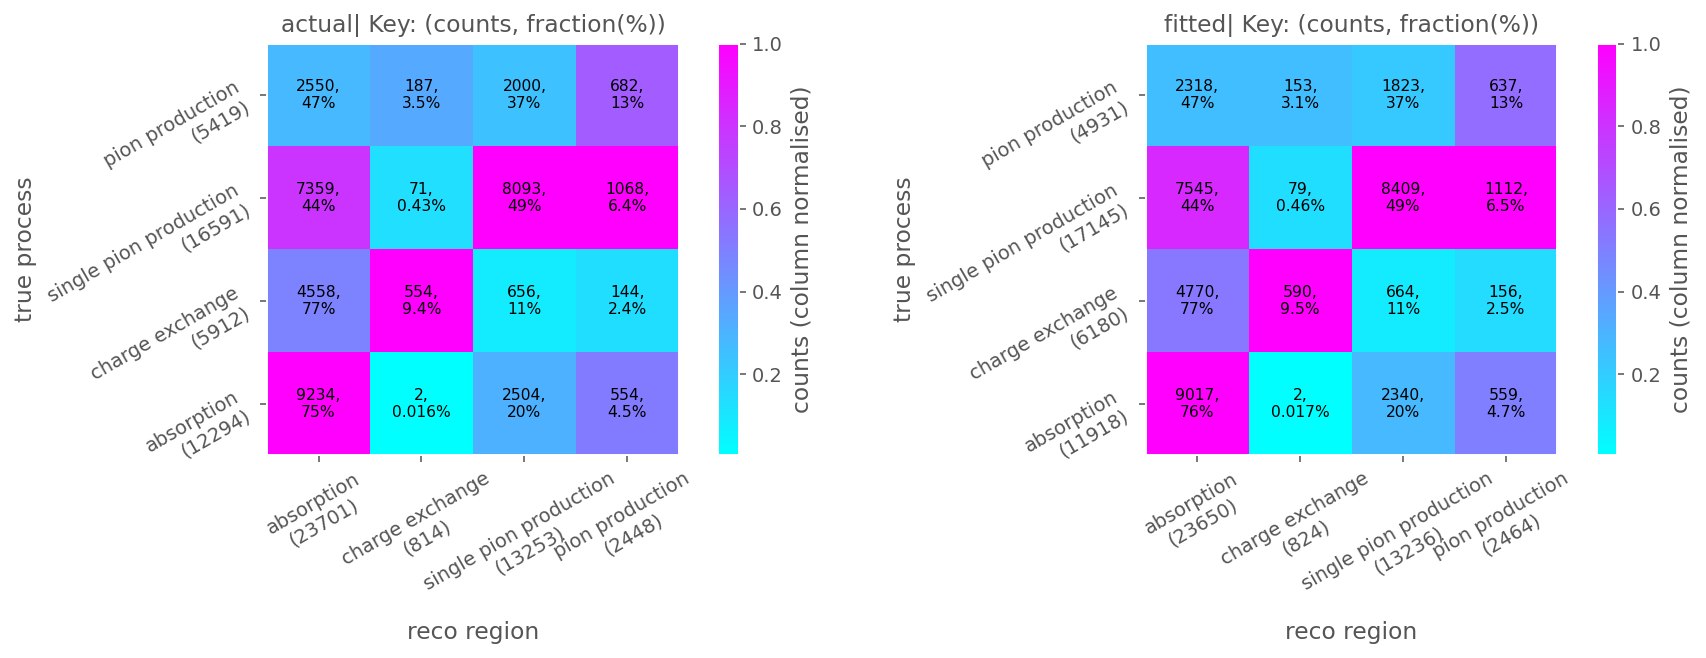

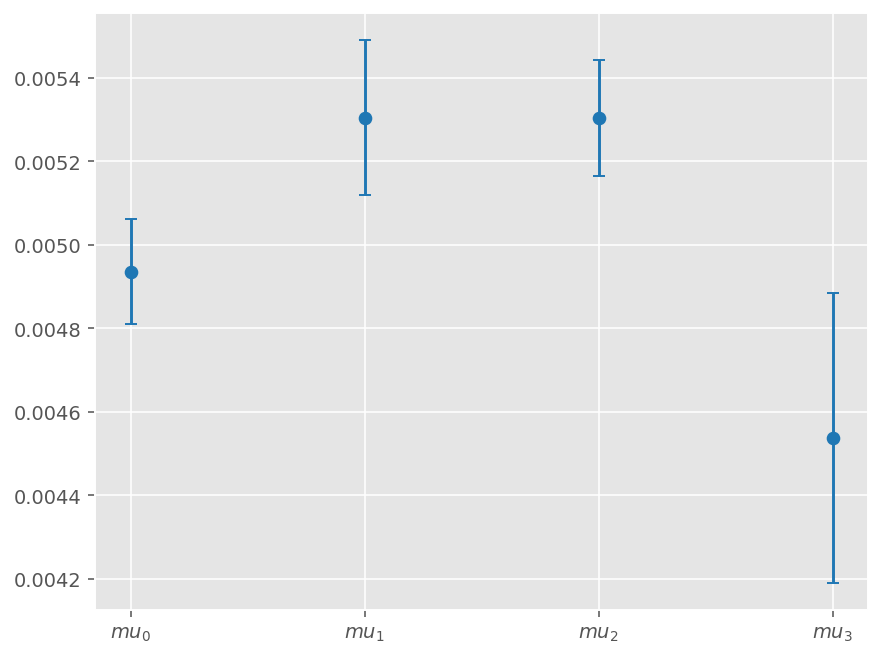

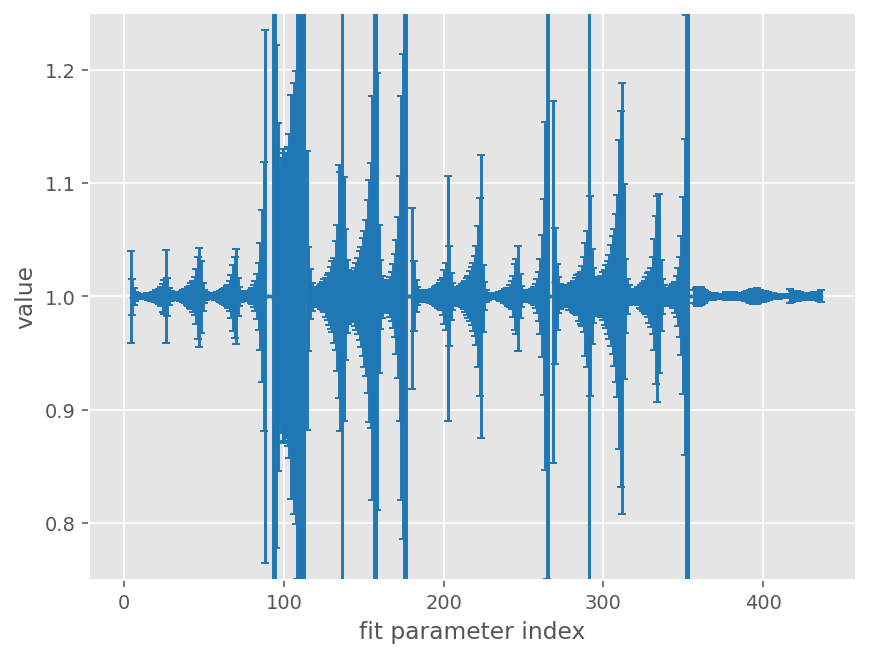

In [45]:
result = RegionFitToyStudy(toy_observed, model, energy_slice, mean_track_score_bins)

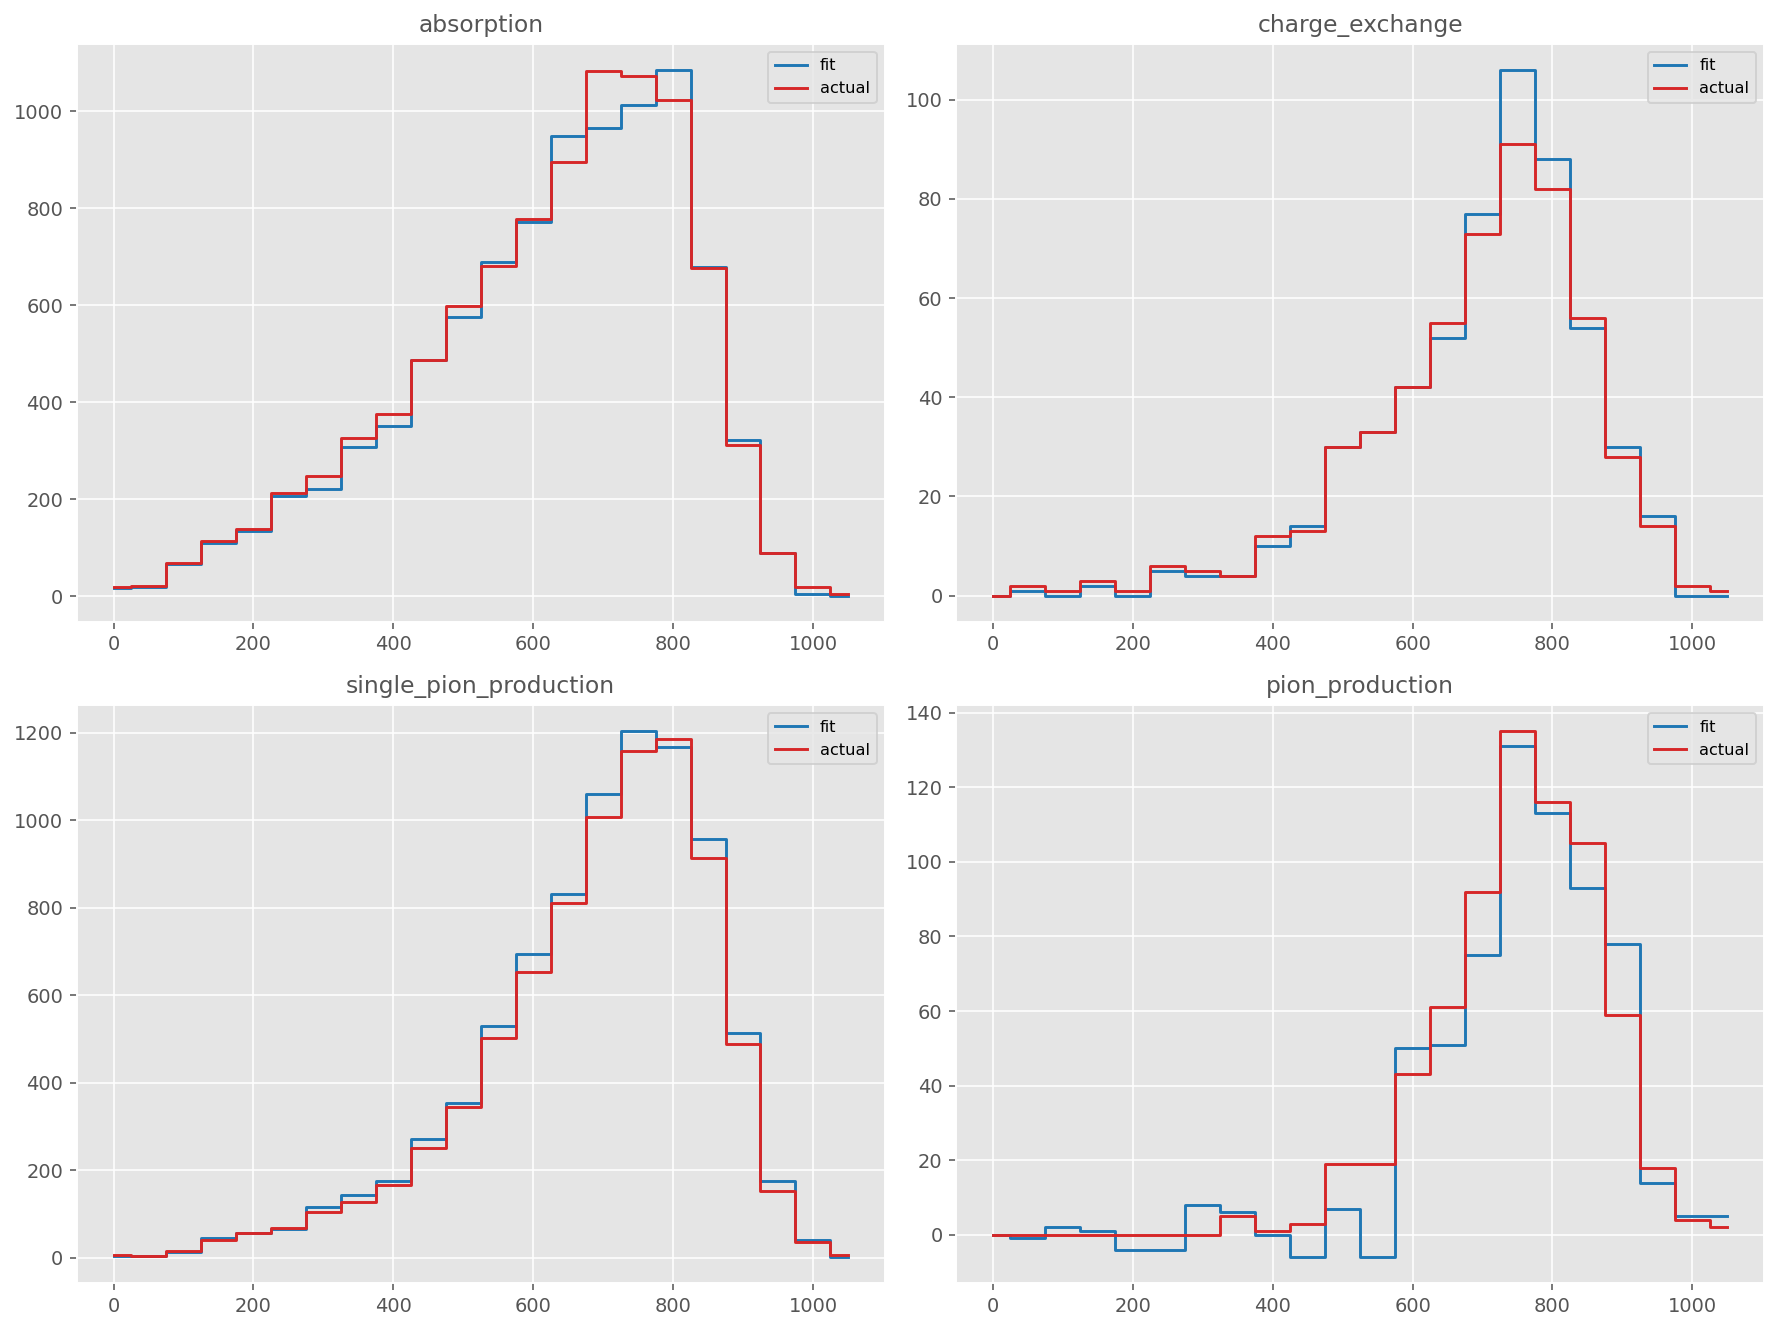

In [50]:
postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = result)
KE_int_prediction = SliceModelPrediction(postfit_pred, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score

n = cross_section.RegionFit.CreateObservedInputData(cross_section.RegionFit.CreateFitInputToy(toy_observed), energy_slice, None)

n_fit = []
for i, (n_c, lambda_c) in enumerate(zip(n, KE_int_prediction.model_yields)):
    # print(i, n_c, lambda_c)
    n_c_fit = n_c
    for j, s in enumerate(lambda_c):
        if j == i: continue
        n_c_fit = n_c_fit - s
    n_fit.append(np.array(n_c_fit.astype(int)))

actual = [cross_section.EnergySlice.CountingExperiment(
    toy_observed.df.KE_int_smeared,
    toy_observed.df.KE_init_smeared,
    (toy_observed.df.z_int_smeared < 0) | (toy_observed.df.z_int_smeared > 700),
    toy_observed.reco_regions[l] & toy_observed.truth_regions[l],
    energy_slice)[0] for l in toy_observed.truth_region_labels]

# n_fit_template = [KE_int_prediction.model_yields[i][i] for i in range(len(KE_int_prediction.model_yields))]

for i in Plots.MultiPlot(len(n_fit)):
    Plots.Plot(energy_slice.pos[:-1], n_fit[i], label = "fit", color = "C0", marker = "x", newFigure = False, style = "step")
    Plots.Plot(energy_slice.pos[:-1], actual[i][:-1], label = "actual", color = "C6", marker = "x", title = toy_observed.truth_region_labels[i], newFigure = False, style = "step")

['absorption', 'charge_exchange', 'single_pion_production', 'pion_production']

signal: charge_exchange

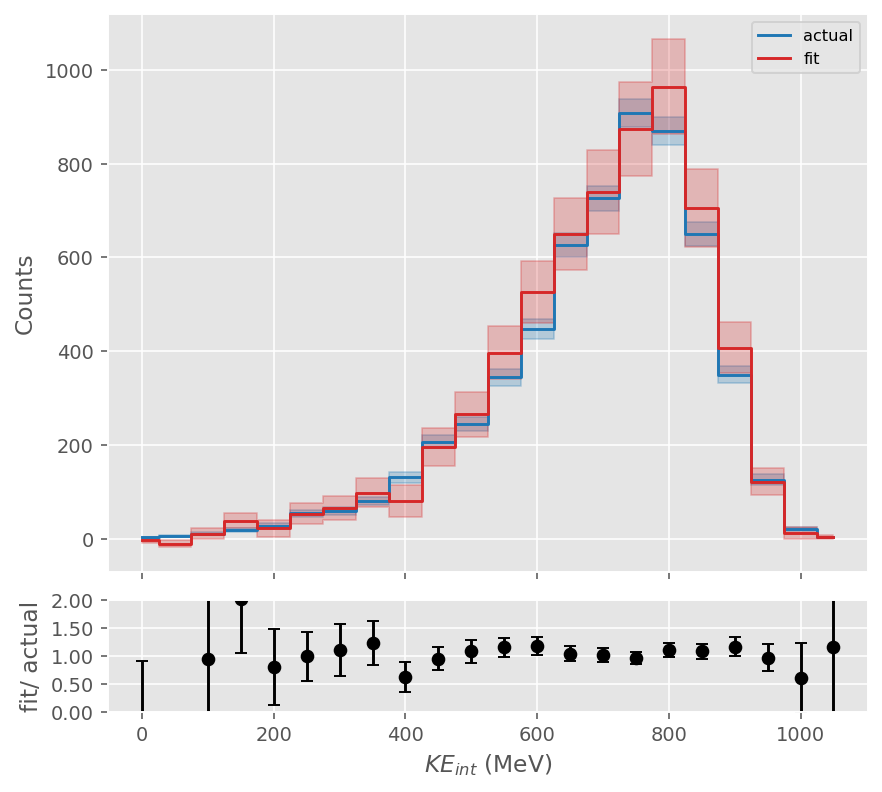

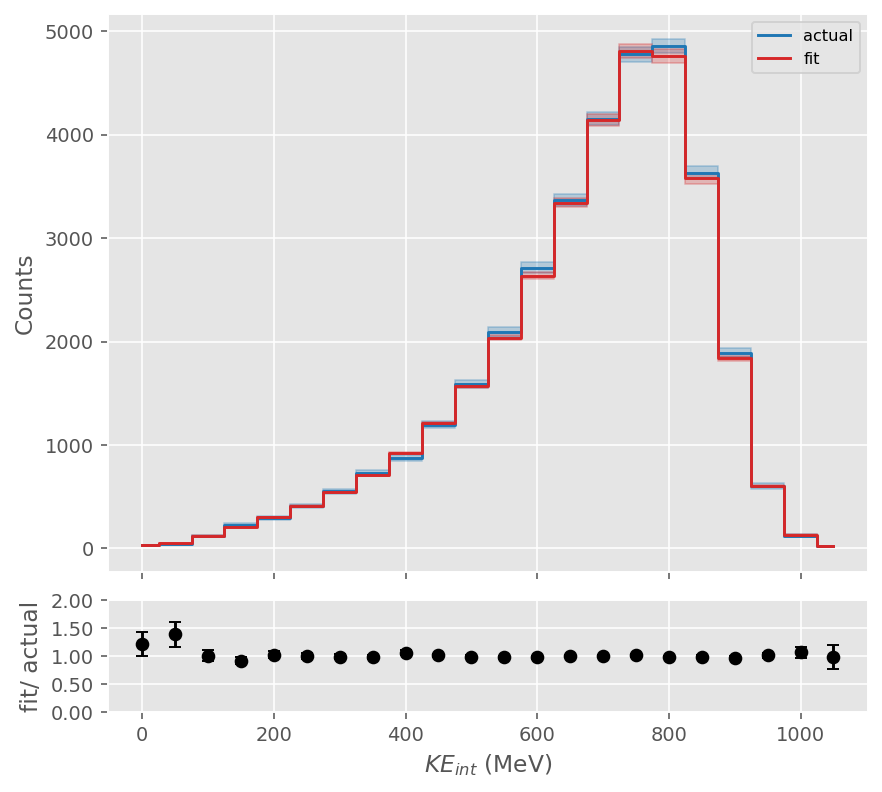

In [51]:
def PlotPrefitPostFit(prefit, prefit_err, postfit, postfit_err):
    with Plots.RatioPlot(energy_slice.pos[:-1], postfit, prefit, postfit_err, prefit_err, "$KE_{int}$ (MeV)", "fit/ actual") as ratio_plot:
        Plots.Plot(ratio_plot.x, ratio_plot.y2, yerr = ratio_plot.y2_err, color = "C0", label = "actual", style = "step", newFigure = False)
        Plots.Plot(ratio_plot.x, ratio_plot.y1, yerr = ratio_plot.y1_err, color = "C6", label = "fit", style = "step", ylabel = "Counts", newFigure = False)

print(toy_input.truth_region_labels)
process = "charge_exchange"
print(f"signal: {process}")

N = sum(n)
# print(f"{N=}")

L = np.sum(KE_int_prediction.model_yields, 0)
# print(f"{L=}")

L_err = KE_int_prediction.total_stdev_model_bins[:, :-1] # last entry in the array is the total error for the whole channel (but we want the total error in each process)
L_err = np.sqrt(np.sum(L_err **2, 0)) # quadrature sum across all bins
# print(L_err)

L_var_bkg = sum(L_err[process != np.array(toy_input.truth_region_labels)]**2)
L_bkg = sum(L[process != np.array(toy_input.truth_region_labels)])

# print(f"{L_bkg=}")
# print(f"{L_var_bkg=}")

KE_int_fit = N - L_bkg
KE_int_fit_err = np.sqrt(N + L_var_bkg)

# print(f"{KE_int_fit=}")
# print(f"{KE_int_fit_err=}")

actual = {l :  toy_observed.NInteract(energy_slice, toy_observed.truth_regions[l]) for l in toy_observed.truth_region_labels}
actual_sig = actual[process]
actual_bkg = sum(np.array(list(actual.values()))[process != np.array(toy_input.truth_region_labels)])

# print(f"{actual_sig=}")
# print(f"{actual_bkg=}")

PlotPrefitPostFit(actual_sig, np.sqrt(actual_sig), KE_int_fit, KE_int_fit_err)
PlotPrefitPostFit(actual_bkg, np.sqrt(actual_bkg), L_bkg, np.sqrt(L_var_bkg))

xs_reco_fit_err=array([21.72417262, 16.75470469, 12.61439699, 10.04602995,  8.94839094,
        8.71827661,  9.02542228,  9.67290153, 10.6707477 , 11.94902992,
       13.45150194, 15.22816398, 17.53015446, 19.64927059, 23.44320035,
       27.94239332, 34.33047826, 41.92396779, 57.00927718, 73.22420608,
       -0.        , -0.        ])

(0.0, 202.1973631173244)

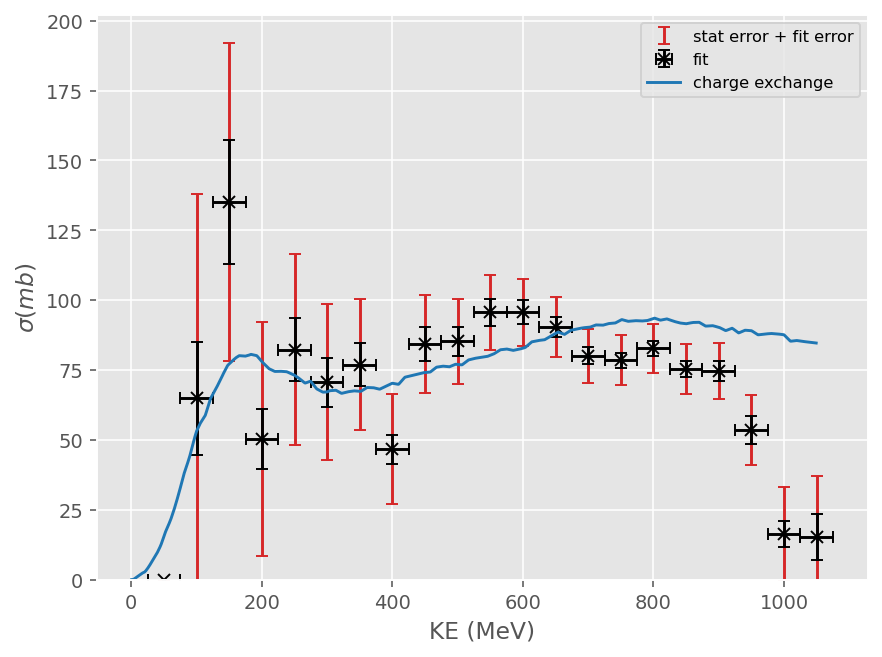

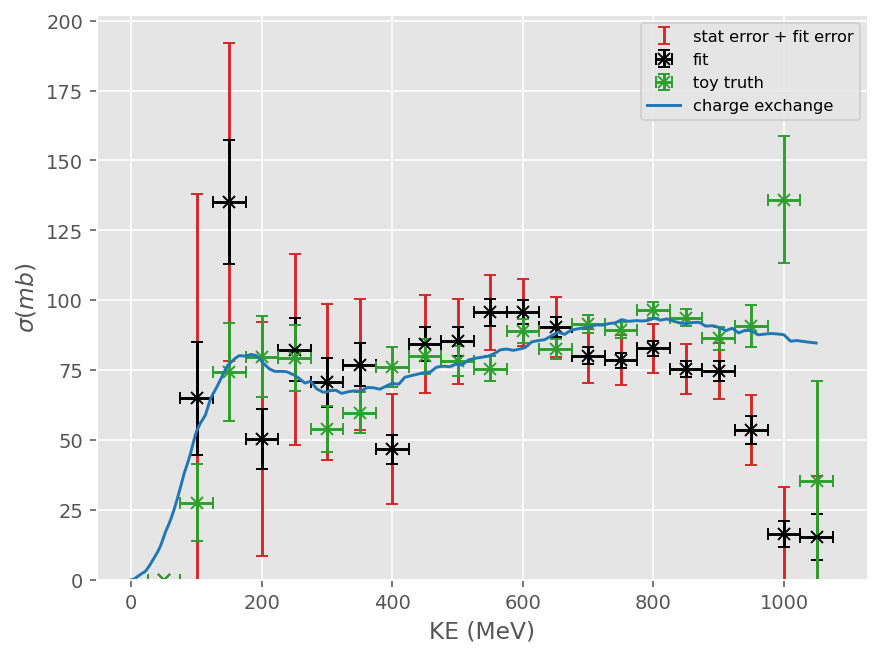

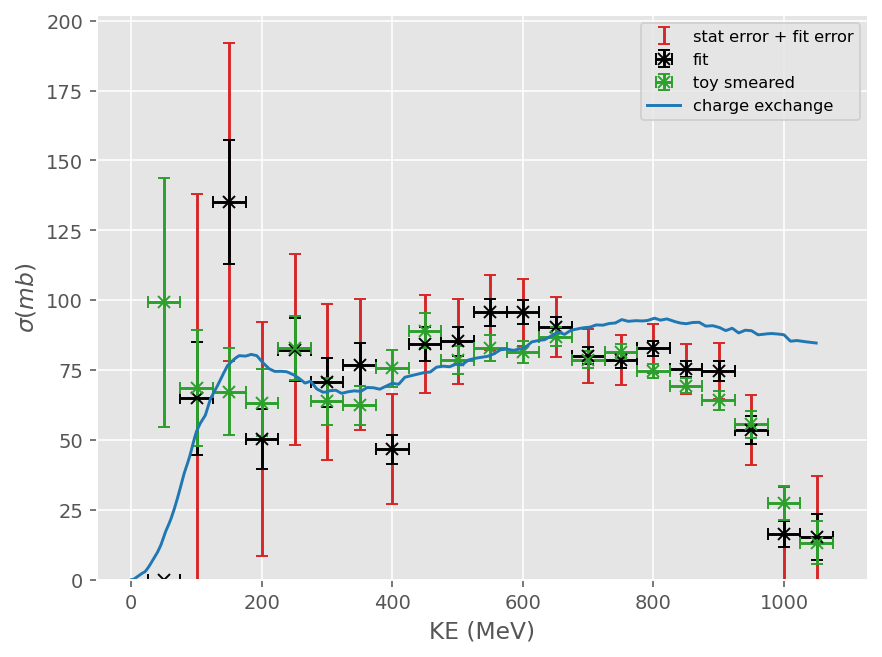

In [52]:
def XSToy(toy : cross_section.Toy, slice_dEdX : np.array, smeared : bool = False):
    KE_int = toy.df.KE_int if smeared is False else toy.df.KE_int_smeared
    KE_init = toy.df.KE_init if smeared is False else toy.df.KE_init_smeared
    outside_tpc = toy.outside_tpc if smeared is False else toy.outside_tpc_smeared

    n_int_inc, n_inc_inc = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.df.inclusive_process != "decay", energy_slice)
    n_int_ex = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.truth_regions[process], energy_slice, interact_only = True)
    xs = cross_section.EnergySlice.ModifiedCrossSection(n_int_ex, n_int_inc, n_inc_inc, slice_dEdX, energy_slice.width)
    output = {"n_interact_exclusive" : n_int_ex, "n_interact_inclusive" : n_int_inc, "n_incident_inclusive" : n_inc_inc, "xs" : xs[0], "xs_err" : xs[1]}
    return output


geant_xs = cross_section.GeantCrossSections(energy_range = [0, 1050])
slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slice, cross_section.Particle.from_pdgid(211))

xs_true = XSToy(toy_observed, slice_dEdX, False)
xs_reco = XSToy(toy_observed, slice_dEdX, True) # smeared

xs_reco_fit = cross_section.EnergySlice.ModifiedCrossSection(np.where(KE_int_fit < 0, 0, KE_int_fit), xs_reco["n_interact_inclusive"][:-1], xs_reco["n_incident_inclusive"][:-1], slice_dEdX[:-1], energy_slice.width)

# xs_reco_fit_err = np.sqrt(np.array(xs_reco_fit[1]**2 + (KE_int_fit_err * xs_reco_fit[0] / KE_int_fit)**2, dtype = float))
xs_reco_fit_err = np.array(KE_int_fit_err * xs_reco_fit[0] / KE_int_fit, dtype = float) # fit error accounts for statistical uncertainty as well

print(f"{xs_reco_fit_err=}")

x = energy_slice.pos[:-2]

Plots.Plot(x, xs_reco_fit[0][:-1], yerr = xs_reco_fit_err[:-1], linestyle = "", marker = "", color = "C6", label = "stat error + fit error")
Plots.Plot(x, xs_reco_fit[0][:-1], xerr = energy_slice.width/2, yerr = xs_reco_fit[1][:-1], linestyle = "", marker = "x", color = "black", label = "fit", newFigure = False)
geant_xs.Plot(process)
plt.ylim(0)

Plots.Plot(x, xs_reco_fit[0][:-1], yerr = xs_reco_fit_err[:-1], linestyle = "", marker = "", color = "C6", label = "stat error + fit error")
Plots.Plot(x, xs_reco_fit[0][:-1], xerr = energy_slice.width/2, yerr = xs_reco_fit[1][:-1], linestyle = "", marker = "x", color = "black", label = "fit", newFigure = False)
Plots.Plot(x, xs_true["xs"][:-2], xerr = energy_slice.width/2, yerr = xs_true["xs_err"][:-2], linestyle = "", marker = "x", color = "C4", label = "toy truth", newFigure = False)
geant_xs.Plot(process)
plt.ylim(0)


Plots.Plot(x, xs_reco_fit[0][:-1], yerr = xs_reco_fit_err[:-1], linestyle = "", marker = "", color = "C6", label = "stat error + fit error")
Plots.Plot(x, xs_reco_fit[0][:-1], xerr = energy_slice.width/2, yerr = xs_reco_fit[1][:-1], linestyle = "", marker = "x", color = "black", label = "fit", newFigure = False)
Plots.Plot(x, xs_reco["xs"][:-2], xerr = energy_slice.width/2, yerr = xs_reco["xs_err"][:-2], linestyle = "", marker = "x", color = "C4", label = "toy smeared", newFigure = False)
geant_xs.Plot(process)
plt.ylim(0)

In [53]:
def weighted_chi_sqr(observed, expected, uncertainties):
    return np.nansum((observed - expected)**2 / uncertainties**2) / len(observed)

sim_curve_interp = cex_toy_generator.interp1d(geant_xs.KE, getattr(geant_xs, process), fill_value = "extrapolate")(x)
weighted_chi_sqrs = {
    "truth": weighted_chi_sqr(xs_true["xs"][:-2], sim_curve_interp, xs_true["xs_err"][:-2]),
    "smeared": weighted_chi_sqr(xs_reco["xs"][:-2], sim_curve_interp, xs_reco["xs_err"][:-2]),
    "fit": weighted_chi_sqr(xs_reco_fit[0][:-1], sim_curve_interp, xs_reco_fit[1][:-1])
}
print(weighted_chi_sqrs)

{'truth': 1.2065856708453861, 'smeared': 21.648188335229932, 'fit': 24.789778562289424}

# ABCD Method

In [ ]:
def ABCDModel(samples : np.array):
    channels = [
        {
            "name": f"channel_0",
            "samples":[
                {
                    "name" : f"sig_A",
                    "data" : samples[0][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_A",
                    "data" : samples[0][1].tolist(),
                    "modifiers" : [
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][1]).astype(int).tolist()}
                        ]
                },

            ]
        },
        {
            "name": f"channel_1",
            "samples":[
                {
                    "name" : f"sig_B",
                    "data" : samples[1][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_B",
                    "data" : samples[1][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_2",
            "samples":[
                {
                    "name" : f"sig_C",
                    "data" : samples[2][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_C",
                    "data" : samples[2][1].tolist(),
                    "modifiers" : [
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_3",
            "samples":[
                {
                    "name" : f"sig_D",
                    "data" : samples[3][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_D",
                    "data" : samples[3][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
    ]
    spec = {"channels" : channels}
    model = cross_section.pyhf.Model(spec, poi_name = "mu_sig")
    return model

def CreateModelInputDataABCD(toy : cross_section.Toy, signal : str, bins : np.array):
    samples_binned = []
    for r in toy.reco_regions:
        samples = []
        for t in toy.truth_regions:
            if t == "charge_exchange":
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & toy.truth_regions[t]], bins)[0])
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & ~toy.truth_regions[t]], bins)[0])
        samples_binned.append(samples)
    return samples_binned


def CreateObservedInputData(toy : cross_section.Toy, energy_bins : np.array, alt_regions : pd.DataFrame = None):
    toy_observed_binned = []

    reco_regions = toy.df.filter(regex = "reco_regions") if alt_regions is None else alt_regions.columns 

    for c in reco_regions:
        m = toy.df[c] if alt_regions is None else alt_regions[c]
        toy_observed_binned.append(np.histogram(toy.df.KE_int_smeared[m], bins = energy_bins)[0])
    if mean_track_score_bins is not None:
        toy_observed_binned.append(np.histogram(toy.df.mean_track_score[toy.df.inclusive_process != "decay"], mean_track_score_bins)[0])
    return toy_observed_binned


def ABCD_MLEScan(toy, model, bins, poi_ind : int, params : np.array):
    observations = cross_section.RegionFit.GenerateObservations(CreateObservedInputData(toy, bins, toy.reco_regions), model)
    # params = np.array(params)
    p = np.linspace(0, 2, 101)
    nll = []
    for i in p:
        params_new = np.array(params)
        params_new[poi_ind] = i
        nll.append(-2 * model.logpdf(params_new, observations)[0])

    Plots.Plot(p, nll, xlabel = model.config.par_names[poi_ind], ylabel = "$-2\ln(L)$", newFigure = False)
    min_ind = np.argmin(nll)
    Plots.Plot(p[min_ind], nll[min_ind], marker = "x", newFigure = False, label = f"minimum | {model.config.par_names[poi_ind]}={p[min_ind]:.3g}, $-2\ln(L)$={nll[min_ind]:.3g}", color = "black")


def ABCD_Study(toy_model : cross_section.Toy, toy_obs : cross_section.Toy, pdf : Plots.PlotBook):
    bins = np.linspace(0, 1050, 22)
    model_alt = ABCDModel(CreateModelInputDataABCD(toy_model, bins))
    observed = cross_section.RegionFit.GenerateObservations(CreateObservedInputData(toy_obs, bins, toy_obs.reco_regions), model_alt)
    result = cross_section.RegionFit.Fit(observed, model_alt, False)

    prefit_pred = cross_section.cabinetry.model_utils.prediction(model_alt)
    postfit_pred = cross_section.cabinetry.model_utils.prediction(model_alt, fit_results = result)
    print(result)

    true_counts = cross_section.Toy.ComputeCounts(toy_obs.truth_regions, toy_obs.reco_regions)
    cex_toy_parameters.PlotCorrelationMatrix(true_counts, toy_obs.truth_region_labels, toy_obs.reco_region_labels)
    pdf.Save()

    titles = toy_model.reco_region_labels

    x = (bins[1:] + bins[:-1]) / 2
    for n, (i, j) in Plots.IterMultiPlot(list(zip(prefit_pred.model_yields, postfit_pred.model_yields))):
        Plots.Plot(x, i[4 + n], label = "prefit signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n].replace("_", " "), newFigure = False)
        Plots.Plot(x, i[n], label = "prefit bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    actual_yield = CreateModelInputDataABCD(toy_obs, bins)
    for n, (i, j, k) in Plots.IterMultiPlot(list(zip(actual_yield, postfit_pred.model_yields, postfit_pred.total_stdev_model_bins))):
        Plots.Plot(x, i[0], label = "actual signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n], newFigure = False)
        Plots.Plot(x, i[1], label = "actual bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], yerr = k[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], yerr = k[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    for i in Plots.MultiPlot(4):
        ABCD_MLEScan(toy_obs, model_alt, bins, i, model_alt.config.suggested_init())
    pdf.Save()
    return

In [ ]:
pdf_valid = Plots.PlotBook("toy_ABCD_valid.pdf", True)
ABCD_Study(toy_input, toy_input, pdf_valid)
pdf_valid.close()

In [ ]:
pdf_vary = Plots.PlotBook("toy_ABCD_vary_regions.pdf", True)
ABCD_Study(toy_input, toy_alt, pdf_vary)
pdf_vary.close()